## problem pid: 50

# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [2]:
import os
import cv2
import csv
import math
import time
import lime  
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TerminateOnNaN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
seed_value = 10 # original

# seed_value = 20 #[RandomSeed]
# seed_value = 42
# seed_value = 64
# seed_value = 100
# seed_value = 123
# seed_value = 200
# seed_value = 456
# seed_value = 1001
# seed_value = 12321


os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU Setting

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [6]:
KeypointsROOT = "../../4_Cut_Video/data/"  ### [Update] 2023/08/03

n_FOLD = 5
n_GAP = 30
n_PERIOD = 50
n_FEATURE = 12 
n_MODEL = 3

isCut1 = True
isCut2_Mirrored = True

Label_dict = {}
allID = []
trainID_5f, validateID_5f, testID_5f = [], [], []
cut1_Dict, cut2_M_Dict = {}, {}

remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

# Load Label

In [7]:
excel_path = "../Label_Data_Info.xlsx" 

df_label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label']) # [update] 2023/06/17
df_label = df_label.fillna(0)
df_label = df_label.astype({"_Label": int})

Label_df = df_label['_Label']
Label_arr = np.array(Label_df)
Label_dict = dict(zip(df_label.編號, df_label._Label))


def checkDataDistribution(KeypointsROOT):
    labelList = []
    for folder in list(os.listdir(KeypointsROOT)):
        if folder != "50":
            label = Label_dict[int(folder)]
            labelList.append(label)
    lableArray = np.array(labelList)
    print(f'Data we have ...')
    print(f'# of AD pid: {np.count_nonzero(lableArray == 1)}')
    print(f'# of NC pid: {np.count_nonzero(lableArray == 0)}')
    print(f'total number of pid: {np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)}\n')
    print(f'Ratio (all guess Positive): {round(np.count_nonzero(lableArray == 1)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    print(f'Ratio (all guess Negative): {round(np.count_nonzero(lableArray == 0)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    
    

checkDataDistribution(KeypointsROOT)

print(f'Number of subjects in "Label_dict": {len(Label_dict)} subjects.\n')
print(Label_dict)

Data we have ...
# of AD pid: 30
# of NC pid: 58
total number of pid: 88

Ratio (all guess Positive): 0.3409
Ratio (all guess Negative): 0.6591
Number of subjects in "Label_dict": 100 subjects.

{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


# Load Age

In [8]:
def read_age_from_csv_file(filename):
    tmp_dict = {}
    df_label = pd.read_excel(filename, usecols=['編號', 'Age'])
    df_label = df_label.fillna(0)
    df_label = df_label.astype({"Age": int})
    
    Label_df = df_label['Age']
    Label_arr = np.array(Label_df)
    tmp_dict = dict(zip(df_label.編號, df_label.Age))
    return tmp_dict

Age_dict = read_age_from_csv_file(excel_path)
print(Age_dict)

{1: 40, 2: 28, 3: 29, 4: 71, 5: 75, 6: 80, 7: 40, 8: 58, 9: 87, 10: 74, 11: 74, 12: 74, 13: 75, 14: 47, 15: 54, 16: 78, 17: 86, 18: 86, 19: 75, 20: 76, 21: 74, 22: 52, 23: 88, 24: 78, 25: 78, 26: 77, 27: 79, 28: 84, 29: 60, 30: 67, 31: 85, 32: 76, 33: 67, 34: 69, 35: 80, 36: 87, 37: 86, 38: 67, 39: 73, 40: 74, 41: 0, 42: 60, 43: 72, 44: 96, 45: 89, 46: 87, 47: 66, 48: 87, 49: 78, 50: 59, 51: 70, 52: 75, 53: 49, 54: 58, 55: 28, 56: 38, 57: 66, 58: 73, 59: 89, 60: 89, 61: 80, 62: 75, 63: 66, 64: 68, 65: 72, 66: 63, 67: 69, 68: 72, 69: 49, 70: 48, 71: 35, 72: 60, 73: 57, 74: 33, 75: 23, 76: 62, 77: 68, 78: 69, 79: 68, 80: 65, 81: 69, 82: 65, 83: 73, 84: 68, 85: 70, 86: 69, 87: 73, 88: 80, 89: 58, 90: 43, 91: 28, 92: 60, 93: 36, 94: 23, 95: 62, 96: 69, 97: 64, 98: 72, 99: 65, 100: 68}


# Load Subject ID

In [9]:
def load_id(KeypointsROOT):
    allID = []
    for folder in list(os.listdir(KeypointsROOT)):
        if folder!="50":
            allID.append(folder)
    return allID


allID = load_id(KeypointsROOT)

print(f'[Info] # of pid: {len(allID)}\n')
print(f'allID:\n{allID}')

[Info] # of pid: 88

allID:
['01', '02', '03', '04', '05', '06', '07', '09', '10', '100', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '43', '44', '45', '46', '48', '49', '51', '52', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


# Split Subject ID (5 fold)

In [10]:
def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/walk_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f


trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'----- trainID_5f: (num: {len(trainID_5f[i])}) -----\n{trainID_5f[i]}')
    print(f'----- validateID_5f: (num: {len(validateID_5f[i])}) -----\n{validateID_5f[i]}')
    print(f'----- testID_5f: (num: {len(testID_5f[i])}) -----\n{testID_5f[i]}\n')    

[Fold 1] Total: 88 subjects.
----- trainID_5f: (num: 56) -----
['17', '18', '20', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '43', '46', '48', '51', '52', '57', '58', '60', '61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '85', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
----- validateID_5f: (num: 14) -----
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
----- testID_5f: (num: 18) -----
['01', '02', '04', '11', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 88 subjects.
----- trainID_5f: (num: 56) -----
['17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '44', '45', '46', '48', '49', '51', '57', '58', '59', '60', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '83', 

In [11]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [12]:
def check_walking_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')


check_walking_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 88 subjects.

[Info] Check for each fold ...
 -fold 1: 88 subjects.
 -fold 2: 88 subjects.
 -fold 3: 88 subjects.
 -fold 4: 88 subjects.
 -fold 5: 88 subjects.


# Load frame number

In [13]:
def countFrames(KeypointsROOT, pidList):
    cut1_dict = {}
    cut2_M_dict = {}
    
    for pid in pidList:
        if isCut1:
            csv_path_keypoints = KeypointsROOT + pid + '/Walking_20240307/' + pid + '_cut1_keypoints1_3.csv' ### [update] 2024/03/07
            if not os.path.exists(csv_path_keypoints):
                print(f'{pid} [cut1] keypoints CSV file does not exist.')
            else:
                df = pd.read_csv(csv_path_keypoints, header=None)
                n_row, n_col = df.shape[0], df.shape[1]
                cut1_dict[pid] = n_row
        if isCut2_Mirrored:
            csv_path_keypoints = KeypointsROOT + pid + '/Walking_20240307/' + pid + '_cut2_keypoints1_3.csv' ### [update] 2024/03/07
            if not os.path.exists(csv_path_keypoints):
                print(f'{pid} [cut2 Mirrored] keypoints CSV file does not exist.')
            else:
                df = pd.read_csv(csv_path_keypoints, header=None)
                n_row, n_col = df.shape[0], df.shape[1]
                cut2_M_dict[pid] = n_row   
    return cut1_dict, cut2_M_dict

cut1_Dict, cut2_M_Dict = countFrames(KeypointsROOT, allID)

print(f'cut1_Dict:\n{cut1_Dict}\n')
print(f'cut2_M_Dict:\n{cut2_M_Dict}')

cut1_Dict:
{'01': 96, '02': 79, '03': 86, '04': 87, '05': 254, '06': 74, '07': 96, '09': 223, '10': 144, '100': 90, '11': 168, '12': 106, '13': 181, '16': 175, '17': 118, '18': 188, '19': 50, '20': 131, '21': 192, '22': 121, '24': 145, '25': 297, '26': 137, '27': 144, '28': 104, '29': 139, '30': 75, '31': 151, '32': 144, '33': 168, '34': 183, '35': 229, '36': 249, '37': 171, '38': 135, '39': 128, '40': 78, '43': 100, '44': 90, '45': 122, '46': 414, '48': 98, '49': 184, '51': 188, '52': 110, '57': 85, '58': 65, '59': 153, '60': 193, '61': 100, '62': 157, '63': 100, '64': 67, '65': 221, '66': 101, '67': 123, '68': 165, '69': 120, '70': 71, '71': 73, '72': 82, '73': 105, '74': 136, '75': 75, '76': 69, '77': 141, '78': 99, '79': 94, '80': 94, '81': 120, '82': 123, '83': 90, '84': 88, '85': 164, '86': 80, '87': 120, '88': 84, '89': 90, '90': 82, '91': 82, '92': 80, '93': 114, '94': 72, '95': 109, '96': 100, '97': 93, '98': 79, '99': 123}

cut2_M_Dict:
{'01': 74, '02': 64, '03': 67, '04': 11

In [14]:
if isCut1==True:
    minFrames = min(cut1_Dict.values())
    maxFrames = max(cut1_Dict.values())
    print(f'[cut1] min: {minFrames}, max: {maxFrames}')
if isCut2_Mirrored==True:
    minFrames = min(cut2_M_Dict.values())
    maxFrames = max(cut2_M_Dict.values())
    print(f'[cut2 Mirrored] min: {minFrames}, max: {maxFrames}')

[cut1] min: 50, max: 414
[cut2 Mirrored] min: 51, max: 423


# Load Coordinate Data (5-Fold)

In [15]:
def normalize_segment(segment):
    n_row, n_col = segment.shape[0], segment.shape[1]

    for i in range(n_col):
        tmpList = [row[i] for row in segment]
        
        tmpArray = np.array(tmpList)
        tmpArray = tmpArray.reshape(len(tmpArray), 1)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaledArray = scaler.fit_transform(tmpArray)
        scaledArray = scaledArray.reshape(-1)
        if i==0:
            resultArray = scaledArray
        else:
            resultArray = np.vstack((resultArray, scaledArray))

    dataScaled = []
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        dataScaled.append([resultArray[0][i], resultArray[1][i],
                           resultArray[2][i], resultArray[3][i],
                           resultArray[4][i], resultArray[5][i],
                           resultArray[6][i], resultArray[7][i],
                           resultArray[8][i], resultArray[9][i],
                           resultArray[10][i], resultArray[11][i]])
    dataScaled = np.array(dataScaled)
    return dataScaled


def create_one_pid_all_segments_data(pid, pts, video_cut):
    n_frame = len(pts)
    n_pair = int((n_frame - int(n_PERIOD)) / int(n_GAP)) + 1 

    start, end = 0, 0
    idxData, xData, yData = [], [], []
    segmentIdx, videoIdx = [], [] ### UPDATE [2024/03/02]
    for i in range(n_pair):
        end = start + int(n_PERIOD)
        
        x = pts[start:end, :]
        x = normalize_segment(x)
        
        x = np.transpose(x).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR) ### RGB image

        y = Label_dict[int(pid)]
        
        xData.append(x)
        yData.append(y)
        idxData.append(int(pid))
        segmentIdx.append(i)
        videoIdx.append(video_cut)

        start += int(n_GAP)   
    return idxData, xData, yData, segmentIdx, videoIdx


def load_data_5fold_normalized_by_segment(KeypointsROOT, trainID, validateID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []

    segmentIdx_5f = [] ### UPDATE [2024/03/02]: Only works on Test Data
    videoIdx_5f = []
    
    for i in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = [], [], []
        idxValidate_1f, xValidate_1f, yValidate_1f = [], [], []
        idxTest_1f, xTest_1f, yTest_1f = [], [], []

        segmentIdx_1f = [] ### UPDATE [2024/03/02]: Only works on Test Data
        videoIdx_1f = []
        
        train_index = trainID[i]
        validate_index = validateID[i]
        test_index = testID[i]
        
        ### ============================================================= Train =============================================================
        for idx in train_index:
            if isCut1:
                csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv' ### [update] 2024/03/07
                
                if not os.path.exists(csv_cut1_norm):
                    print(f'{idx} [cut1] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut1_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")

                    idxTrain_1f.extend(idxData)
                    xTrain_1f.extend(xData) 
                    yTrain_1f.extend(yData)
            if isCut2_Mirrored:
                csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv' ### [update] 2024/03/07
                if not os.path.exists(csv_cut2_M_norm):
                    print(f'{idx} [cut2 Mirrored] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut2_M_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                    
                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                    
                    idxTrain_1f.extend(idxData)
                    xTrain_1f.extend(xData)
                    yTrain_1f.extend(yData)
        
        idxTrain_5f.append(idxTrain_1f)
        xTrain_5f.append(xTrain_1f)
        yTrain_5f.append(yTrain_1f)
        
        
        ### ============================================================= Validation =============================================================
        for idx in validate_index:
            if isCut1:
                csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv' ### [update] 2024/03/07
                if not os.path.exists(csv_cut1_norm):
                    print(f'{idx} [cut1] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut1_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")

                    idxValidate_1f.extend(idxData)
                    xValidate_1f.extend(xData)
                    yValidate_1f.extend(yData)
            if isCut2_Mirrored:
                csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv' ### [update] 2024/03/07
                if not os.path.exists(csv_cut2_M_norm):
                    print(f'{idx} [cut2 Mirrored] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut2_M_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                    
                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                    
                    idxValidate_1f.extend(idxData)
                    xValidate_1f.extend(xData)
                    yValidate_1f.extend(yData)
        
        idxValidate_5f.append(idxValidate_1f)
        xValidate_5f.append(xValidate_1f)
        yValidate_5f.append(yValidate_1f)
        
        
        ### ============================================================= Test =============================================================
        for idx in test_index:
            if isCut1:
                csv_cut1_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut1_keypoints1_3.csv' ### [update] 2024/03/07
                if not os.path.exists(csv_cut1_norm):
                    print(f'[Test] {idx} [cut1] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut1_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                    
                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut1")
                    
                    idxTest_1f.extend(idxData)
                    xTest_1f.extend(xData)
                    yTest_1f.extend(yData)
                    segmentIdx_1f.extend(segmentIdx) ### UPDATE [2024/03/02]
                    videoIdx_1f.extend(videoIdx)
            if isCut2_Mirrored:
                csv_cut2_M_norm = KeypointsROOT + idx + '/Walking_20240307/' + idx + '_cut2_keypoints1_3.csv' ### [update] 2024/03/07
                if not os.path.exists(csv_cut2_M_norm):
                    print(f'[Test] {idx} [cut2 Mirrored] CSV does not exist.')
                else:
                    df = pd.read_csv(csv_cut2_M_norm, header=None)
                    coord_df = df.iloc[:, :]
                    coord_arr = coord_df.values
                    coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                    
                    idxData, xData, yData, segmentIdx, videoIdx = create_one_pid_all_segments_data(idx, coord_arr, "cut2M")
                    
                    idxTest_1f.extend(idxData)
                    xTest_1f.extend(xData)
                    yTest_1f.extend(yData) 
                    segmentIdx_1f.extend(segmentIdx) ### UPDATE [2024/03/02]
                    videoIdx_1f.extend(videoIdx)

        idxTest_5f.append(idxTest_1f)
        xTest_5f.append(xTest_1f)
        yTest_5f.append(yTest_1f)
        segmentIdx_5f.append(segmentIdx_1f) ### UPDATE [2024/03/02]
        videoIdx_5f.append(videoIdx_1f)
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f, videoIdx_5f

In [16]:
print(f'[INFO] Normalize data by each segment.')
idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f, videoIdx_5f \
        = load_data_5fold_normalized_by_segment(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)

[INFO] Normalize data by each segment.


In [17]:
for i in range(n_FOLD):
    ### ========================= Train =========================
    tmpIdx_train = np.array(idxTrain_5f[i])
    tmpX_train = np.array(xTrain_5f[i])
    tmpY_train = np.array(yTrain_5f[i])
    
    tmpIdx_train, tmpX_train, tmpY_train = shuffle(tmpIdx_train, tmpX_train, tmpY_train)
    
    idxTrain_5f[i] = tmpIdx_train
    xTrain_5f[i] = tmpX_train
    yTrain_5f[i] = tmpY_train
    
    ### ========================= Validation =========================
    tmpIdx_val = np.array(idxValidate_5f[i])
    tmpX_val = np.array(xValidate_5f[i])
    tmpY_val = np.array(yValidate_5f[i])
    
    tmpIdx_val, tmpX_val, tmpY_val = shuffle(tmpIdx_val, tmpX_val, tmpY_val)
    
    idxValidate_5f[i] = tmpIdx_val
    xValidate_5f[i] = tmpX_val
    yValidate_5f[i] = tmpY_val
    
    ### ========================= Test =========================
    tmpIdx_test = np.array(idxTest_5f[i])
    tmpX_test = np.array(xTest_5f[i])
    tmpY_test = np.array(yTest_5f[i])
    tmpSegIdx_test = np.array(segmentIdx_5f[i])
    tmpVideoIdx_test = np.array(videoIdx_5f[i])
    
    ### UPDATE [2024/03/02] Do NOT shuffle the Testing data
    tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test, tmpVideoIdx_test = shuffle(tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test, tmpVideoIdx_test)
    
    idxTest_5f[i] = tmpIdx_test
    xTest_5f[i] = tmpX_test
    yTest_5f[i] = tmpY_test
    segmentIdx_5f[i] = tmpSegIdx_test
    videoIdx_5f[i] = tmpVideoIdx_test

print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')

print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}, (VideoIdx): {videoIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (329, 12, 50), (Validate): (87, 12, 50), (Test): (103, 12, 50)
- Fold 2 (Train): (329, 12, 50), (Validate): (73, 12, 50), (Test): (117, 12, 50)
- Fold 3 (Train): (330, 12, 50), (Validate): (86, 12, 50), (Test): (103, 12, 50)
- Fold 4 (Train): (327, 12, 50), (Validate): (99, 12, 50), (Test): (93, 12, 50)
- Fold 5 (Train): (325, 12, 50), (Validate): (91, 12, 50), (Test): (103, 12, 50)

[Target Data]
- Fold 1 (Train): (329,), (Validate): (87,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 2 (Train): (329,), (Validate): (73,), (Test): (117,), (SegIdx): (117,), (VideoIdx): (117,)
- Fold 3 (Train): (330,), (Validate): (86,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)
- Fold 4 (Train): (327,), (Validate): (99,), (Test): (93,), (SegIdx): (93,), (VideoIdx): (93,)
- Fold 5 (Train): (325,), (Validate): (91,), (Test): (103,), (SegIdx): (103,), (VideoIdx): (103,)


In [18]:
for i in range(n_FOLD):
    tmpY = np.array(yTrain_5f[i])
    print(f'- [Fold {i+1}] Train:    (AD): {np.count_nonzero(tmpY==1)}, (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yValidate_5f[i])
    print(f'  [Fold {i+1}] Validate: (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yTest_5f[i])
    print(f'  [Fold {i+1}] Test:     (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')

- [Fold 1] Train:    (AD): 170, (NC): 159
  [Fold 1] Validate: (AD): 32,  (NC): 55
  [Fold 1] Test:     (AD): 49,  (NC): 54
- [Fold 2] Train:    (AD): 170, (NC): 159
  [Fold 2] Validate: (AD): 33,  (NC): 40
  [Fold 2] Test:     (AD): 48,  (NC): 69
- [Fold 3] Train:    (AD): 171, (NC): 159
  [Fold 3] Validate: (AD): 33,  (NC): 53
  [Fold 3] Test:     (AD): 47,  (NC): 56
- [Fold 4] Train:    (AD): 168, (NC): 159
  [Fold 4] Validate: (AD): 37,  (NC): 62
  [Fold 4] Test:     (AD): 46,  (NC): 47
- [Fold 5] Train:    (AD): 154, (NC): 171
  [Fold 5] Validate: (AD): 36,  (NC): 55
  [Fold 5] Test:     (AD): 61,  (NC): 42


In [19]:
### Check if Test data shuffle or not
for i in range(n_FOLD):
    for pid in testID_5f[i]:
        tmp_idx = np.where(idxTest_5f[i]==int(pid))[0]
        tmp_seg = [segmentIdx_5f[i][idx] for idx in tmp_idx]
        tmp_video = [videoIdx_5f[i][idx] for idx in tmp_idx]
        print(f'[pid {pid}] n_pairs: {len(tmp_idx)}, seg: {tmp_seg}, video: {tmp_video}')

[pid 01] n_pairs: 3, seg: [0, 0, 1], video: ['cut1', 'cut2M', 'cut1']
[pid 02] n_pairs: 2, seg: [0, 0], video: ['cut1', 'cut2M']
[pid 04] n_pairs: 5, seg: [0, 0, 2, 1, 1], video: ['cut2M', 'cut1', 'cut2M', 'cut1', 'cut2M']
[pid 11] n_pairs: 9, seg: [1, 1, 0, 2, 3, 0, 3, 4, 2], video: ['cut1', 'cut2M', 'cut1', 'cut1', 'cut2M', 'cut2M', 'cut1', 'cut2M', 'cut2M']
[pid 29] n_pairs: 6, seg: [2, 1, 1, 0, 0, 2], video: ['cut2M', 'cut1', 'cut2M', 'cut2M', 'cut1', 'cut1']
[pid 34] n_pairs: 11, seg: [4, 4, 0, 3, 5, 1, 2, 0, 3, 1, 2], video: ['cut2M', 'cut1', 'cut2M', 'cut2M', 'cut2M', 'cut2M', 'cut2M', 'cut1', 'cut1', 'cut1', 'cut1']
[pid 36] n_pairs: 12, seg: [4, 6, 5, 0, 1, 2, 3, 3, 0, 1, 4, 2], video: ['cut2M', 'cut1', 'cut1', 'cut2M', 'cut2M', 'cut2M', 'cut1', 'cut2M', 'cut1', 'cut1', 'cut1', 'cut1']
[pid 37] n_pairs: 8, seg: [0, 2, 0, 4, 1, 3, 2, 1], video: ['cut1', 'cut2M', 'cut2M', 'cut1', 'cut1', 'cut1', 'cut1', 'cut2M']
[pid 44] n_pairs: 4, seg: [1, 1, 0, 0], video: ['cut2M', 'cut1', 'c

# Feature Selection (Dynamic)

## Select Features

In [20]:
threshold_5fold_list = []
f1score_5fold_list = []

LOAD_MODEL_FOLDER = "LOG/Walking_RandomSeed/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
LOAD_PARAMETER_FOLDER = "LOG/Walking_RandomSeed/" + str(seed_value) + "/Parameters/"
print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')
print(f'Load thresholds from FOLDER:    {LOAD_PARAMETER_FOLDER}\n')

def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
    return threshold_list, f1score_list

threshold_5fold_list, f1score_5fold_list = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'Threshold:\n{threshold_5fold_list}\n')
print(f'F1-Score:\n{f1score_5fold_list}')

Load model weights from FOLDER: LOG/Walking_RandomSeed/10/Model_Weights/
Load thresholds from FOLDER:    LOG/Walking_RandomSeed/10/Parameters/

Threshold:
[0.4800000000000001, 0.4, 0.4, 0.4, 0.4]

F1-Score:
[0.4827586206896552, 0.625, 0.5208333333333334, 0.5225225225225225, 0.5185185185185185]


In [21]:
def fs_make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def feature_selection_with_GradCAM_dynamic():
    selected_feature_idx = []
    sum_of_each_feature = [0] * n_FEATURE

    
    for fold_idx in range(n_FOLD):
        ### Load trained model ----------------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Load data -------------------------------------------------------------------
        valID_1f = validateID_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]
        threshold = threshold_5fold_list[fold_idx]
 
        ### Feature Selection with Validation Data ---------------------------------------
        for pid in valID_1f:
            pid = int(pid)
            label = Label_dict[pid]

            prob_list = []
            for idx in range(len(idxVal_1f)):
                tmp_pid = idxVal_1f[idx]
                if tmp_pid == pid:
                    data = xVal_1f[idx]
                    n_feature, n_timestamp = data.shape[0], data.shape[1]
                    data = np.expand_dims(data, axis=0)
                    data = data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)
                    tmp_prob = model.predict(data)
                    prob_list.append(tmp_prob)

            target_prob, target_index = 0, 0
            if label==0:
                target_prob, target_index = np.min(prob_list), np.argmin(prob_list)
            if label==1:
                target_prob, target_index = np.max(prob_list), np.argmax(prob_list)

            ### Run on target most important data ------------------------------------------------
            target_data = xVal_1f[target_index]
            n_feature, n_timestamp = target_data.shape[0], target_data.shape[1]
            target_data = np.expand_dims(target_data, axis=0)
            target_data = target_data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)
            
            heatmap = fs_make_gradcam_heatmap(target_data, model, 'last_conv') 
            heatmap = np.uint8(255*heatmap)
            # heatmap = cv2.resize(heatmap, (n_timestamp, n_feature))
            for feature_idx, value in enumerate(heatmap):
                sum_of_each_feature[feature_idx] += np.average(value)
                
    sum_of_each_feature_scaled = sum_of_each_feature.copy()
    tmp_sum = np.sum(sum_of_each_feature_scaled)
    for fidx, feat in enumerate(sum_of_each_feature_scaled):
        sum_of_each_feature_scaled[fidx] = 1/tmp_sum * sum_of_each_feature_scaled[fidx]
    
    sum_of_each_feature_scaled_sort = sum_of_each_feature_scaled.copy()
    sum_of_each_feature_scaled_sort.sort()

    imp_sumup = 0
    selected_feature_idx = []
    for impIdx, imp in reversed(list(enumerate(sum_of_each_feature_scaled_sort))):
        imp_sumup += imp
        selected_feature_idx.append(impIdx)
        print(f'[impIdx, imp, sum] = [{impIdx}, {imp}, {imp_sumup}]')
        if imp_sumup > 0.8:
            break
    selected_feature_idx.sort()
    return selected_feature_idx


selected_features = []
selected_features = feature_selection_with_GradCAM_dynamic()

n_SELECTED_FEATURE = len(selected_features)

print(f'\nn_SELECTED_FEATURE = {n_SELECTED_FEATURE}')
print(f'\nFeature selected with validation data:\n{len(selected_features)} features: {selected_features}')

[impIdx, imp, sum] = [11, 0.12211631862775471, 0.12211631862775471]
[impIdx, imp, sum] = [10, 0.11565708181438134, 0.23777340044213605]
[impIdx, imp, sum] = [9, 0.0985315076527251, 0.33630490809486113]
[impIdx, imp, sum] = [8, 0.09639064724153668, 0.4326955553363978]
[impIdx, imp, sum] = [7, 0.08998813930167626, 0.5226836946380741]
[impIdx, imp, sum] = [6, 0.08748465047595527, 0.6101683451140294]
[impIdx, imp, sum] = [5, 0.0696796389599939, 0.6798479840740232]
[impIdx, imp, sum] = [4, 0.06812614057763956, 0.7479741246516628]
[impIdx, imp, sum] = [3, 0.06737557394346831, 0.8153496985951311]

n_SELECTED_FEATURE = 9

Feature selected with validation data:
9 features: [3, 4, 5, 6, 7, 8, 9, 10, 11]


In [22]:
SAVE_PARAMETER_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Parameters/" # [RandomSeed]
print(f'Save thresholds to FOLDER:    {SAVE_PARAMETER_FOLDER}')

def save_feature_index_to_CSV():
    if not os.path.exists(SAVE_PARAMETER_FOLDER):
        os.makedirs(SAVE_PARAMETER_FOLDER)
    feature_file_name = SAVE_PARAMETER_FOLDER + 'featureIdx_5fold.csv'
    df_selected_feature_idx = pd.DataFrame(selected_features)
    df_selected_feature_idx.to_csv(feature_file_name, index=False, header=False)
        
save_feature_index_to_CSV()

Save thresholds to FOLDER:    LOG_FS/Walking_RandomSeed_FS/10/Parameters/


## Reload data with selected features

In [20]:
n_MODEL = 3
MAX_EPOCHS = 50
BATCH_SIZE = 32
Threshold = 0.5

n_SELECTED_FEATURE = 6

best_threshold_5f_List = []
best_f1score_5f_List = []


SAVE_MODEL_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
SAVE_PARAMETER_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Parameters/" 

print(f'Save model weights to FOLDER:\n{SAVE_MODEL_FOLDER}\n')
print(f'Save thresholds to FOLDER:\n{SAVE_PARAMETER_FOLDER}')

Save model weights to FOLDER:
LOG_FS/Walking_RandomSeed_FS/10/Model_Weights/

Save thresholds to FOLDER:
LOG_FS/Walking_RandomSeed_FS/10/Parameters/


In [21]:
selected_features = []
n_SELECTED_FEATURE = 0

def read_featureIdx_from_csv(featureIdx_file_name):
    featureIdx_list = []
    df = pd.read_csv(featureIdx_file_name, header=None)
    n_row, n_col = df.shape[0], df.shape[1]
    for i in range(n_row):
        featureIdx_list.append(df.iloc[i, :].values[0])
    return featureIdx_list

# selected_features = read_featureIdx_from_csv(SAVE_PARAMETER_FOLDER + 'featureIdx_5fold.csv')
selected_features = read_featureIdx_from_csv("LOG_FS/Walking_RandomSeed_FS/10/Parameters/featureIdx_5fold.csv")

n_SELECTED_FEATURE = len(selected_features)

print(f'n_SELECTED_FEATURE = {n_SELECTED_FEATURE}')
print(f'\nselected_features: {selected_features}')

n_SELECTED_FEATURE = 9

selected_features: [3, 4, 5, 6, 7, 8, 9, 10, 11]


In [22]:
new_xTrain_5f, new_xVal_5f, new_xTest_5f = [], [], []

def feature_selection_reconstruct_data():
    tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f = [], [], []
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]

        tmp_xTrain_1f, tmp_xVal_1f, tmp_xTest_1f = [], [], []

        top_feature_idx = selected_features

        for data in xTrain_1f:
            data = data[top_feature_idx]
            tmp_xTrain_1f.append(data)
        tmp_xTrain_1f = np.array(tmp_xTrain_1f)
        tmp_xTrain_5f.append(tmp_xTrain_1f)
        
        for data in xVal_1f:
            data = data[top_feature_idx]
            tmp_xVal_1f.append(data)
        tmp_xVal_1f = np.array(tmp_xVal_1f)
        tmp_xVal_5f.append(tmp_xVal_1f)

        for data in xTest_1f:
            data = data[top_feature_idx]
            tmp_xTest_1f.append(data)
        tmp_xTest_1f = np.array(tmp_xTest_1f)
        tmp_xTest_5f.append(tmp_xTest_1f)
    return tmp_xTrain_5f, tmp_xVal_5f, tmp_xTest_5f


new_xTrain_5f, new_xVal_5f, new_xTest_5f = feature_selection_reconstruct_data()


print(f'[Feature Selection]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {new_xTrain_5f[i].shape}, (Validate): {new_xVal_5f[i].shape}, (Test): {new_xTest_5f[i].shape}')

[Feature Selection]
- Fold 1 (Train): (329, 9, 50), (Validate): (87, 9, 50), (Test): (103, 9, 50)
- Fold 2 (Train): (329, 9, 50), (Validate): (73, 9, 50), (Test): (117, 9, 50)
- Fold 3 (Train): (330, 9, 50), (Validate): (86, 9, 50), (Test): (103, 9, 50)
- Fold 4 (Train): (327, 9, 50), (Validate): (99, 9, 50), (Test): (93, 9, 50)
- Fold 5 (Train): (325, 9, 50), (Validate): (91, 9, 50), (Test): (103, 9, 50)


## Training

### Train & Save models

In [23]:
def build_model_structure():
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(1, 3), activation='relu', strides=1, padding='same', input_shape=(n_SELECTED_FEATURE, int(n_PERIOD), 1), name='first_conv')) 
    model.add(Conv2D(16, kernel_size=(1, 3), activation='relu', strides=1, padding='same', name='last_conv'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [24]:
best_threshold_5f_List = []
best_f1score_5f_List = []

def find_best_threshold_tuning(yTrue, yPred_prob):
    scores = []
    thresholds = np.arange(0.40, 0.60, 0.01)
    # thresholds = np.arange(0.30, 0.70, 0.01)
    for t in thresholds:
        yPred = (yPred_prob >= t).astype('int')
        score = f1_score(yTrue, yPred)
        scores.append(score)
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    best_f1score = scores[ix]
    return best_threshold, best_f1score


def feature_selection_training_and_Save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], new_xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], new_xVal_5f[fold_idx], yValidate_5f[fold_idx]
        
        xTrain_1f = xTrain_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1) ### shape = (n_samples, 6, 300, 1)
        xVal_1f = xVal_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1)

        best_auc = 0
        best_model_idx = 0
        best_threshold = 0

        for model_idx in range(n_MODEL):
            print(f'[Feature Selection] Training for [Fold {fold_idx+1}] model {model_idx+1} ...')
            model = build_model_structure()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = model.fit(xTrain_1f, yTrain_1f, 
                                epochs=MAX_EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                validation_data=(xVal_1f, yVal_1f), 
                                shuffle=True, 
                                verbose=0)
            
            yPred_val = model.predict(xVal_1f)
            aucScore_val = roc_auc_score(yVal_1f, yPred_val)
            if aucScore_val > best_auc:
                best_auc = aucScore_val
                best_model = model

        ### Use F1-Score & Validation Data to Find threshold which will be used with Test Data ----------
        yPred_val = best_model.predict(xVal_1f)
        best_threshold, best_f1score = find_best_threshold_tuning(yVal_1f, yPred_val)
        best_threshold_5f_List.append(best_threshold)
        best_f1score_5f_List.append(best_f1score)

        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVE_MODEL_FOLDER):
            os.makedirs(SAVE_MODEL_FOLDER)
        best_model.save(f'{SAVE_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(best_model.summary())

    if not os.path.exists(SAVE_PARAMETER_FOLDER):
        os.makedirs(SAVE_PARAMETER_FOLDER)
    threshold_file_name = SAVE_PARAMETER_FOLDER + 'threshold_5fold.csv'
    f1score_file_name = SAVE_PARAMETER_FOLDER + 'f1Score_5fold.csv'
    with open(threshold_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_threshold_5f_List)
    with open(f1score_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_f1score_5f_List)


feature_selection_training_and_Save_model()

[Feature Selection] Training for [Fold 1] model 1 ...
[Feature Selection] Training for [Fold 1] model 2 ...
[Feature Selection] Training for [Fold 1] model 3 ...
[Feature Selection] Training for [Fold 2] model 1 ...
[Feature Selection] Training for [Fold 2] model 2 ...
[Feature Selection] Training for [Fold 2] model 3 ...
[Feature Selection] Training for [Fold 3] model 1 ...
[Feature Selection] Training for [Fold 3] model 2 ...
[Feature Selection] Training for [Fold 3] model 3 ...
[Feature Selection] Training for [Fold 4] model 1 ...
[Feature Selection] Training for [Fold 4] model 2 ...
[Feature Selection] Training for [Fold 4] model 3 ...
[Feature Selection] Training for [Fold 5] model 1 ...
[Feature Selection] Training for [Fold 5] model 2 ...
[Feature Selection] Training for [Fold 5] model 3 ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv (Conv2D)          (None,

## Evaluate & Results

### Average

In [23]:
best_threshold_5f_List = []
best_f1score_5f_List = []

LOAD_MODEL_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
LOAD_PARAMETER_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Parameters/"

def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
    return threshold_list, f1score_list

best_threshold_5f_List, best_f1score_5f_List = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'best_threshold_5f_List:\n{best_threshold_5f_List}\n')
print(f'best_f1score_5f_List:\n{best_f1score_5f_List}')

best_threshold_5f_List:
[0.4, 0.5100000000000001, 0.4, 0.4, 0.43000000000000005]

best_f1score_5f_List:
[0.425, 0.5714285714285714, 0.5473684210526316, 0.5272727272727272, 0.4742268041237113]


In [24]:
actual_label_List= []
predict_label_List = []

result_dict = {}
result_dict_sorted = {}

result_segment_dict = {}
result_segment_dict_sorted = {}

def check_performance_with_best_threshold(idxList, answerList, predictionList, best_threshold):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)
    n_Correct = 0

    ### Loop through each pid in test list
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        prob = 0
        
        ### get the actual label (target) of this pid
        actual_label = Label_dict[pid]

        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                prob += round(predictionList[j][0], 4)
                
        ### calculate the average prediction prob of this pid
        avegProb = prob / nPairs
        
        if avegProb >= best_threshold:
            predict_label = 1
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)    
        else:
            predict_label = 0
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)
            
        if predict_label==actual_label:
            n_Correct += 1
        
        result_dict[pid] = {}
        result_dict[pid]["avegProb"] = round(avegProb, 4)
        result_dict[pid]["n_pairs"] = nPairs
        result_dict[pid]["prediction"] = predict_label
        result_dict[pid]["actual"] = actual_label
    return n_Correct, len(uniqueID_test)

def get_prob_of_each_segment(pidList, segmentList, videoList, prediction):
    for i in range(len(pidList)):
        pid = pidList[i]
        seg = segmentList[i]
        video = videoList[i]
        pred = prediction[i]
        if pid not in result_segment_dict:
            result_segment_dict[pid] = {}
        segName = str(video) + "_segment_" + str(seg)
        result_segment_dict[pid][segName] = round(pred[0], 4)

In [25]:
actual_label_List= []
predict_label_List = []

result_dict = {}
result_dict_sorted = {}

result_segment_dict = {}
result_segment_dict_sorted = {}


def load_model_and_evaluate_model():
    metrics_auc_5f = []
    metrics_acc_5f = []
    metrics_loss_5f = []
    nb_correction_5f = []
    nb_testing_5f = []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1) ### grayscale image
        # xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3) ### RGB image

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        auc = roc_auc_score(yTest_1f, yPred)
        metrics_auc_5f.append(round(auc, 2))
        scores = model.evaluate(xTest_1f, yTest_1f, verbose=0)
        metrics_acc_5f.append(round(scores[1], 2))
        metrics_loss_5f.append(round(scores[0], 2))

        # ### Check model performance with Threshold(=0.5) or best_threshold
        threshold = best_threshold_5f_List[fold_idx]
        nb_correction, nb_testing = check_performance_with_best_threshold(idxTest_1f, yTest_1f, yPred, threshold)
        get_prob_of_each_segment(idxTest_1f, segmentIdx_1f, videoIdx_1f, yPred)
        nb_correction_5f.append(nb_correction)
        nb_testing_5f.append(nb_testing)
    return nb_correction_5f, nb_testing_5f, metrics_auc_5f, metrics_acc_5f, metrics_loss_5f


correctionList, testNumList, aucList, accList, lossList = load_model_and_evaluate_model()

In [26]:
result_segment_dict[59]

{'cut2M_segment_1': 0.0324,
 'cut1_segment_3': 1.0,
 'cut2M_segment_0': 0.9404,
 'cut1_segment_0': 0.9801,
 'cut2M_segment_3': 0.0178,
 'cut1_segment_2': 0.1624,
 'cut2M_segment_2': 0.9968,
 'cut1_segment_1': 1.0,
 'cut2M_segment_4': 1.0,
 'cut2M_segment_5': 0.9991}

In [27]:
total_Correction, total_Pid = 0, 0
for i in range(n_FOLD):
    print(f'- Fold {i+1}: {correctionList[i]}/{testNumList[i]}, AUC: {aucList[i]}, accuracy: {accList[i]}, loss: {lossList[i]}')
    total_Correction += correctionList[i]
    total_Pid += testNumList[i]
    
print(f'Performance: {total_Correction}/{total_Pid}, Ratio: {round(total_Correction/total_Pid*100, 2)}%')

- Fold 1: 10/18, AUC: 0.65, accuracy: 0.57, loss: 1.42
- Fold 2: 11/18, AUC: 0.57, accuracy: 0.5, loss: 1.72
- Fold 3: 12/18, AUC: 0.56, accuracy: 0.52, loss: 1.25
- Fold 4: 11/17, AUC: 0.69, accuracy: 0.66, loss: 1.02
- Fold 5: 16/17, AUC: 0.8, accuracy: 0.69, loss: 0.63
Performance: 60/88, Ratio: 68.18%


==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        58
           1       0.52      0.83      0.64        30

    accuracy                           0.68        88
   macro avg       0.70      0.72      0.68        88
weighted avg       0.75      0.68      0.69        88

==================  Performance  ====================
0) TN: 35, FP: 23, FN: 5, TP: 25
1) Accuracy: 68.18%
2) Sensitivity (Recall): 83.33%
3) Specificity: 60.34%
4) G-Mean: 70.91%
5) Precision: 52.08%
6) F1-Score: 0.64
7) F2-Measure: 0.74



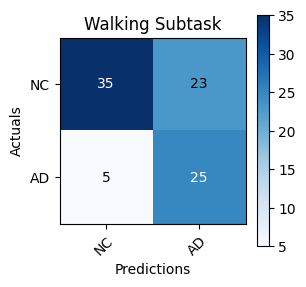

In [28]:
from mlxtend.plotting import plot_confusion_matrix

def show_confusion_matrix():
    actual_label_array = np.array(actual_label_List)
    predict_label_array = np.array(predict_label_List)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Walking Subtask', fontsize=12)
    plt.show()


    
show_confusion_matrix()

### Weighted

In [29]:
import sys

==================  Performance  ====================
0) TN: 51, FP: 7, FN: 1, TP: 29
1) Accuracy: 90.91%
2) Sensitivity (Recall): 96.67%
3) Specificity: 87.93%
4) G-Mean: 92.2%
5) Precision: 80.56%
6) F1-Score: 0.88
7) F2-Measure: 0.93



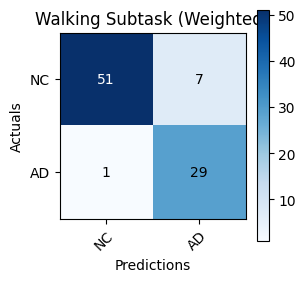

In [30]:
result_weighted_dict = {}
result_weighted_dict_sorted = {}

def evaluate_model_with_confidence():
    actual_label_weighted_List= []
    predict_label_weighted_List = []
    for fold_idx in range(n_FOLD):
        testID = testID_5f[fold_idx]
        for pid in testID:
            result = result_segment_dict[int(pid)]
            predict_label = 0
            label = Label_dict[int(pid)]
            threshold = best_threshold_5f_List[fold_idx]

            segmentName, prediction = [], []
            for key in result:
                prediction.append(result_segment_dict[int(pid)][key])
                segmentName.append(key)
            prediction = np.array(prediction)
            minPred, minIdx = np.min(prediction), np.argmin(prediction)
            maxPred, maxIdx = np.max(prediction), np.argmax(prediction)
            # print(f'[Pid {pid}] Label={label} {prediction}\nmin: {minPred}, {minIdx}\nmax: {maxPred}, {maxIdx}')

            mean_weighted = 0
            if label==0: ### NC
                eps = sys.float_info.epsilon
                prediction = [w if w != 0 else eps for w in prediction]
                prediction = np.array(prediction)
                mean_weighted = np.average(prediction, weights=1/prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=1/prediction)}\n')
            if label==1: ### AD
                mean_weighted = np.average(prediction, weights=prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=prediction)}\n')

            if mean_weighted >= threshold: predict_label = 1
            else: predict_label = 0
                
            actual_label_weighted_List.append(label)
            if mean_weighted >= threshold: predict_label_weighted_List.append(predict_label)
            else: predict_label_weighted_List.append(predict_label)

            result_weighted_dict[int(pid)] = {}
            result_weighted_dict[int(pid)]["avegProb_weighted"] = round(mean_weighted, 4)
            result_weighted_dict[int(pid)]["prediction"] = predict_label
            result_weighted_dict[int(pid)]["actual"] = label
    

    ### Confusion Matrix ----------------------------------------------------------------------------------------
    actual_label_weighted_array, predict_label_weighted_array = np.array(actual_label_weighted_List), np.array(predict_label_weighted_List)
    matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Walking Subtask (Weighted)', fontsize=12)
    plt.show()


evaluate_model_with_confidence() 

In [31]:
def check_the_difference_between_two_results(): ### result_dict, result_weighted_dict
    if len(result_dict) != len(result_weighted_dict):
        print(f'!!! NOTICE !!! Elements in two result_dict & result_weighted_dict are not the same!')
    for key in result_dict:
        pred1 = result_dict[key]["prediction"]
        prob1 = result_dict[key]["avegProb"]
        pred2 = result_weighted_dict[key]["prediction"]
        prob2 = result_weighted_dict[key]["avegProb_weighted"]
        truth = result_dict[key]["actual"]
        if pred1 != pred2:
            print(f'[Pid {key}] Label: {truth}, Pred: {pred1}({prob1}) -> {pred2}({prob2})')


check_the_difference_between_two_results()

[Pid 2] Label: 0, Pred: 1(0.4938) -> 0(0.0007999999797903001)
[Pid 29] Label: 0, Pred: 1(0.5543) -> 0(0.01360000018030405)
[Pid 34] Label: 0, Pred: 1(0.4227) -> 0(0.03920000046491623)
[Pid 37] Label: 1, Pred: 0(0.216) -> 1(0.5807999968528748)
[Pid 83] Label: 0, Pred: 1(0.4293) -> 0(0.2433999925851822)
[Pid 5] Label: 0, Pred: 1(0.7063) -> 0(0.37380000948905945)
[Pid 21] Label: 0, Pred: 1(0.8183) -> 0(0.3601999878883362)
[Pid 61] Label: 1, Pred: 0(0.2933) -> 1(0.7833999991416931)
[Pid 65] Label: 1, Pred: 0(0.4946) -> 1(0.9287999868392944)
[Pid 66] Label: 0, Pred: 1(0.5813) -> 0(0.02979999966919422)
[Pid 93] Label: 0, Pred: 1(0.6967) -> 0(0.01810000091791153)
[Pid 20] Label: 1, Pred: 0(0.3203) -> 1(0.628000020980835)
[Pid 72] Label: 0, Pred: 1(0.4852) -> 0(0.3772999942302704)
[Pid 79] Label: 0, Pred: 1(0.6466) -> 0(0.011900000274181366)
[Pid 19] Label: 0, Pred: 1(0.4844) -> 0(0.023099999874830246)
[Pid 51] Label: 0, Pred: 1(0.4655) -> 0(0.18719999492168427)
[Pid 74] Label: 0, Pred: 1(0.52

In [32]:
print(result_segment_dict.keys())
result_segment_dict[60]

dict_keys([29, 44, 49, 11, 34, 59, 36, 45, 37, 81, 75, 2, 83, 67, 4, 89, 1, 94, 82, 52, 5, 10, 96, 21, 93, 65, 35, 62, 66, 61, 91, 87, 43, 12, 90, 70, 69, 33, 60, 48, 57, 68, 46, 79, 97, 13, 20, 3, 86, 71, 72, 40, 28, 76, 31, 38, 85, 51, 27, 100, 78, 16, 99, 19, 26, 84, 30, 32, 74, 6, 95, 25, 22, 63, 17, 24, 18, 39, 7, 9, 73, 77, 92, 80, 98, 88, 58, 64])


{'cut2M_segment_4': 0.3682,
 'cut1_segment_3': 0.8438,
 'cut1_segment_1': 0.9482,
 'cut2M_segment_3': 0.9162,
 'cut1_segment_0': 0.2122,
 'cut1_segment_2': 0.952,
 'cut2M_segment_0': 0.2529,
 'cut1_segment_4': 0.1388,
 'cut2M_segment_2': 0.8407,
 'cut2M_segment_1': 0.5801}

### Grad-CAM
* Keras Source Code: https://keras.io/examples/vision/grad_cam/

In [108]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



def show_GradCAM_result_withoutResize():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{SAVE_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        testID = testID_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]

        selected_feature = selected_features

        feature_name_list = ['xHipAdd', 'xKneeAdd', 'xAnkleAdd', 'xHipMinus', 'xKneeMinus', 'xAnkleMinus', 
                             'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
        new_feature_name_list = []
        for feat_idx in selected_feature:
            new_feature_name_list.append(feature_name_list[feat_idx])
        print(f'selected_feature: {selected_feature}')
        print(f'new_feature_name_list: {new_feature_name_list}')

        for idx, pid in enumerate(idxTest_1f):
            if pid==61:
                test_data = xTest_1f[idx]
                test_data = np.expand_dims(test_data, axis=0)

                segIdx = segmentIdx_1f[idx]
                vtype = videoIdx_1f[idx]
                prob =  result_segment_dict[pid][str(vtype) + "_segment_" + str(segIdx)]
                label = Label_dict[pid]
                pred_average =  result_dict[pid]["prediction"]
                pred_weighted = result_weighted_dict[pid]["prediction"]
                
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv')
                heatmap = np.uint8(255*heatmap)
                print(f'heatmap.shape = {heatmap.shape}')
                
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
                print(f'------------------------------- [Pid {pid}] [Fold {fold_idx}] Prob: {prob}, Segment: {segIdx}, Video: {vtype} -------------------------------')
                print(f'--------------------------------- Label: {label}, Pred_average: {pred_average}, Pred_weighted: {pred_weighted}  ------------------------------')
                plt.figure(figsize=(24, 12))
                for featureIdx in range(n_SELECTED_FEATURE):
                    plt.subplot(3, 3, featureIdx+1)
                    plt.title(f'Feature: {new_feature_name_list[featureIdx]}', fontsize=10)
                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show() 




def show_GradCAM_with_higher_confidence_withoutResize():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{SAVE_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        testID = testID_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]

        selected_feature = selected_features

        feature_name_list = ['xHipAdd', 'xKneeAdd', 'xAnkleAdd', 'xHipMinus', 'xKneeMinus', 'xAnkleMinus', 
                             'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
        new_feature_name_list = []
        for feat_idx in selected_feature:
            new_feature_name_list.append(feature_name_list[feat_idx])
        print(f'selected_feature: {selected_feature}')
        print(f'new_feature_name_list: {new_feature_name_list}')

        for pid in testID:
            pid = int(pid)
            label = Label_dict[pid]
            pred_average = result_dict[pid]["prediction"]
            pred_weighted = result_weighted_dict[pid]["prediction"]
            confidence_idx = 0
            confidence_value = 0
            if label==0:
                confidence_value = 100
            confidence_segment = 0
            confidence_vtype = 0
            # if pid == 59:
            # if pid==10 or pid==11 or pid==12 or pid==31 or pid==59 or pid==62:
            if pid==60:
                if label==1:
                    for testIdx, testPid in enumerate(idxTest_1f):
                        if testPid == pid:
                            seg = segmentIdx_1f[testIdx]
                            vtype = videoIdx_1f[testIdx]
                            prob =  result_segment_dict[pid][str(vtype) + "_segment_" + str(seg)]
                            if prob > confidence_value:
                                confidence_value = prob
                                confidence_idx = testIdx
                                confidence_segment = seg
                                confidence_vtype = vtype
                elif label==0:
                    for testIdx, testPid in enumerate(idxTest_1f):
                        if testPid == pid:
                            seg = segmentIdx_1f[testIdx]
                            vtype = videoIdx_1f[testIdx]
                            prob =  result_segment_dict[pid][str(vtype) + "_segment_" + str(seg)]
                            if prob < confidence_value:
                                confidence_value = prob
                                confidence_idx = testIdx
                                confidence_segment = seg
                                confidence_vtype = vtype
                test_data = xTest_1f[confidence_idx]
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0)
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv') 
                heatmap = np.uint8(255*heatmap)
                print(f'heatmap.shape = {heatmap.shape}')
                # heatmap = cv2.resize(heatmap, (width, height))    
            
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
                print(f'------------------------------- [Pid {pid}] [Fold {fold_idx}] Prob: {confidence_value}, Segment: {confidence_segment}, Video: {confidence_vtype} -------------------------------')
                print(f'--------------------------------- Label: {label}, Pred_average: {pred_average}, Pred_weighted: {pred_weighted}  ------------------------------')
                plt.figure(figsize=(24, 12))
                for featureIdx in range(n_SELECTED_FEATURE):
                    plt.subplot(3, 3, featureIdx+1)
                    plt.title(f'Feature: {new_feature_name_list[featureIdx]}', fontsize=10)
                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()   




selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
heatmap.shape = (9, 50)
------------------------------- [Pid 61] [Fold 1] Prob: 0.9710999727249146, Segment: 0, Video: cut2M -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


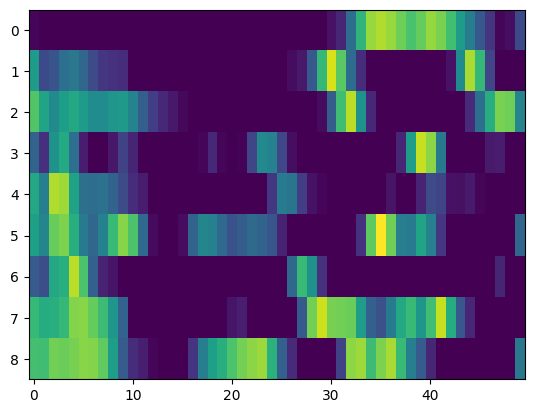

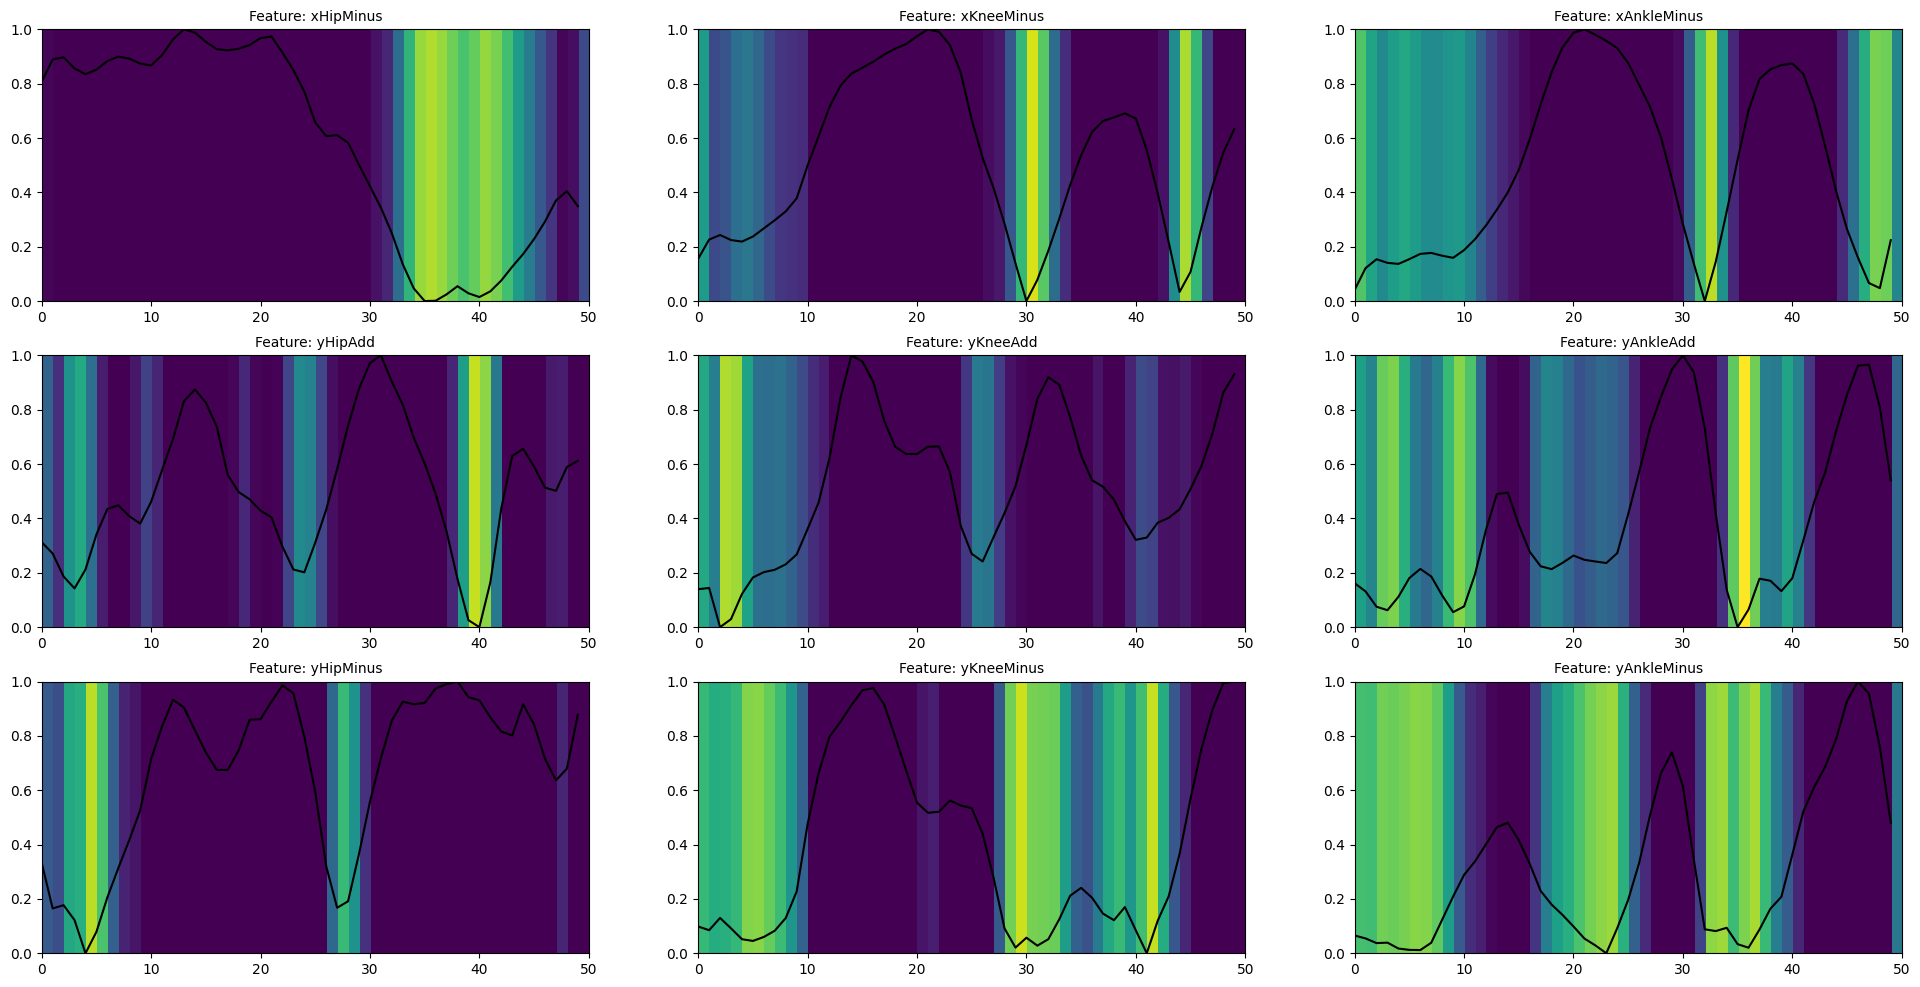

heatmap.shape = (9, 50)
------------------------------- [Pid 61] [Fold 1] Prob: 0.04470000043511391, Segment: 0, Video: cut1 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


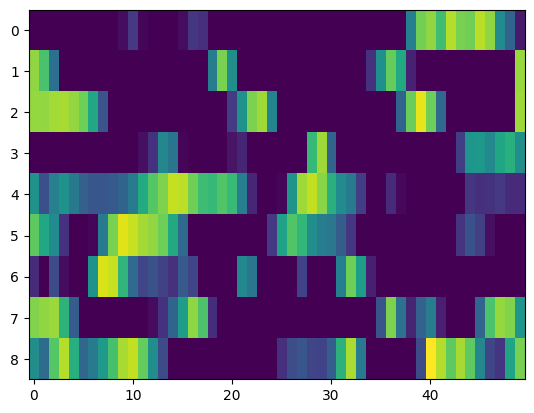

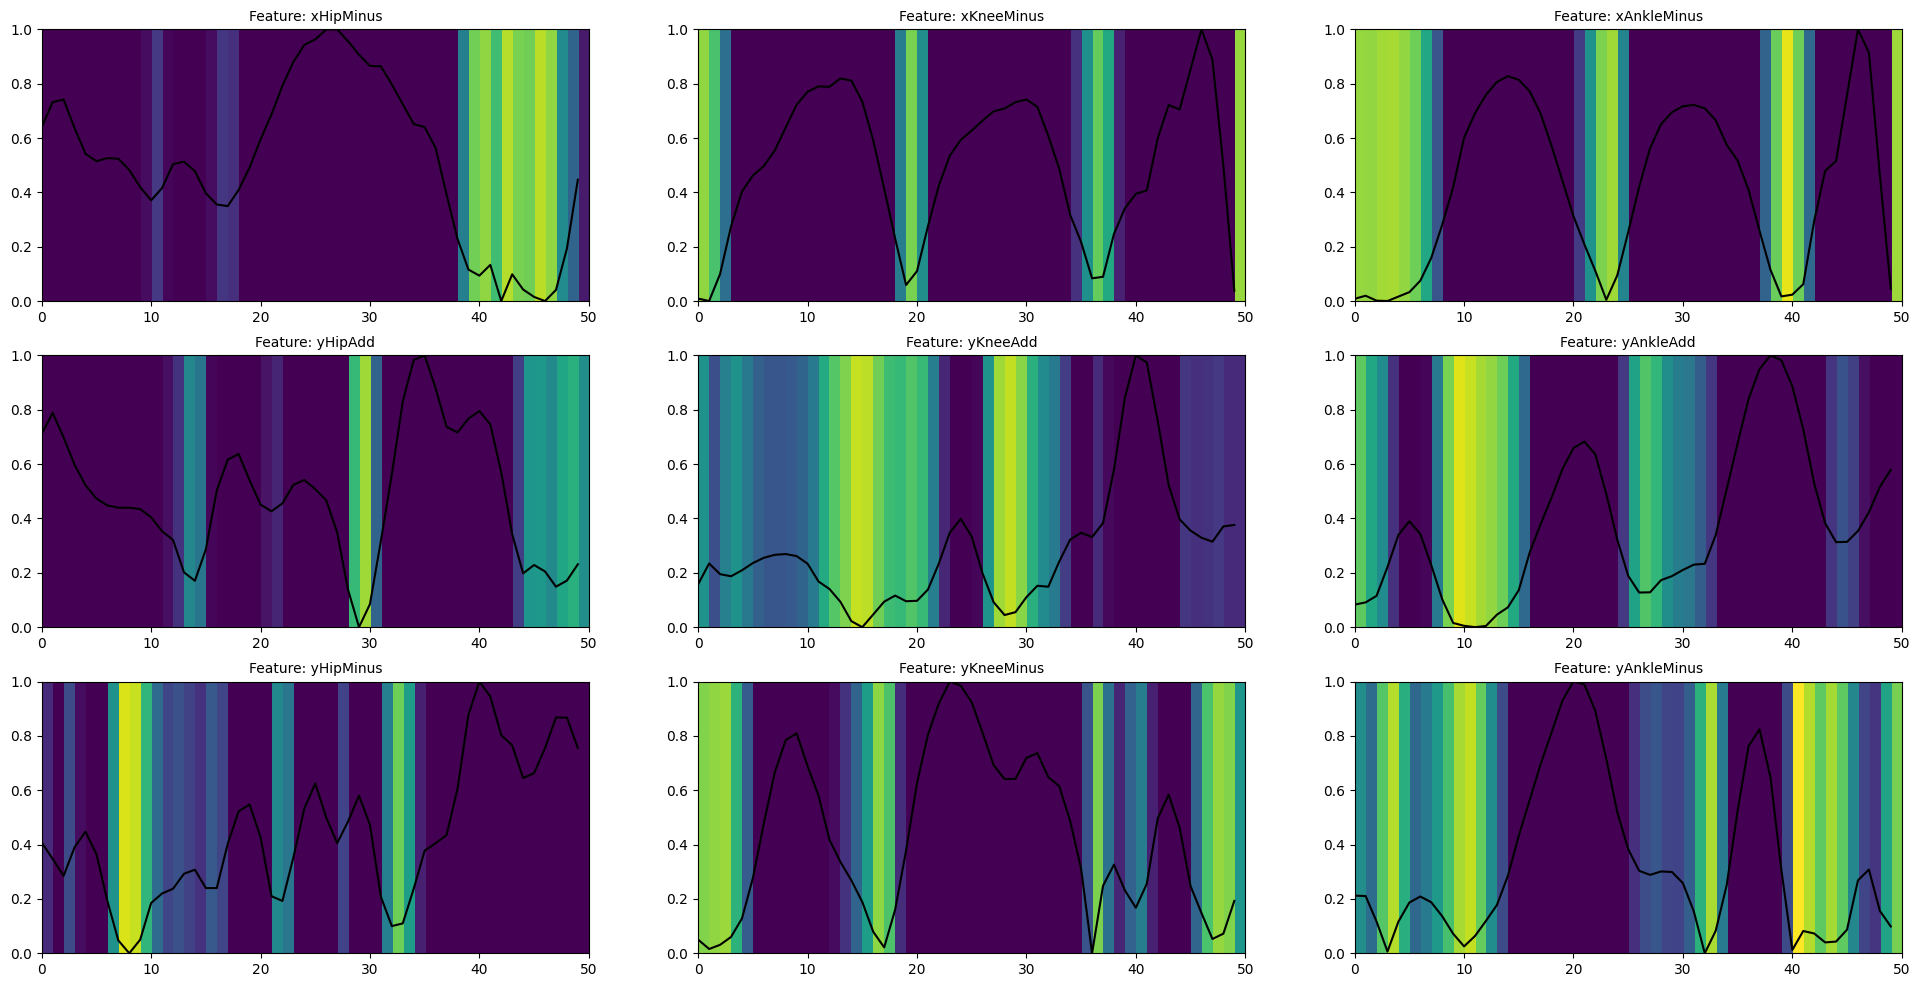

heatmap.shape = (9, 50)
------------------------------- [Pid 61] [Fold 1] Prob: 0.00139999995008111, Segment: 1, Video: cut2M -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


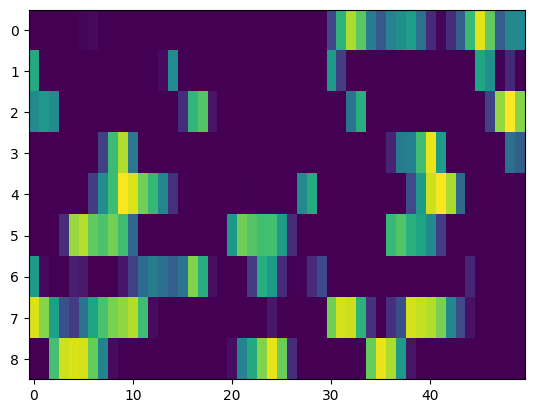

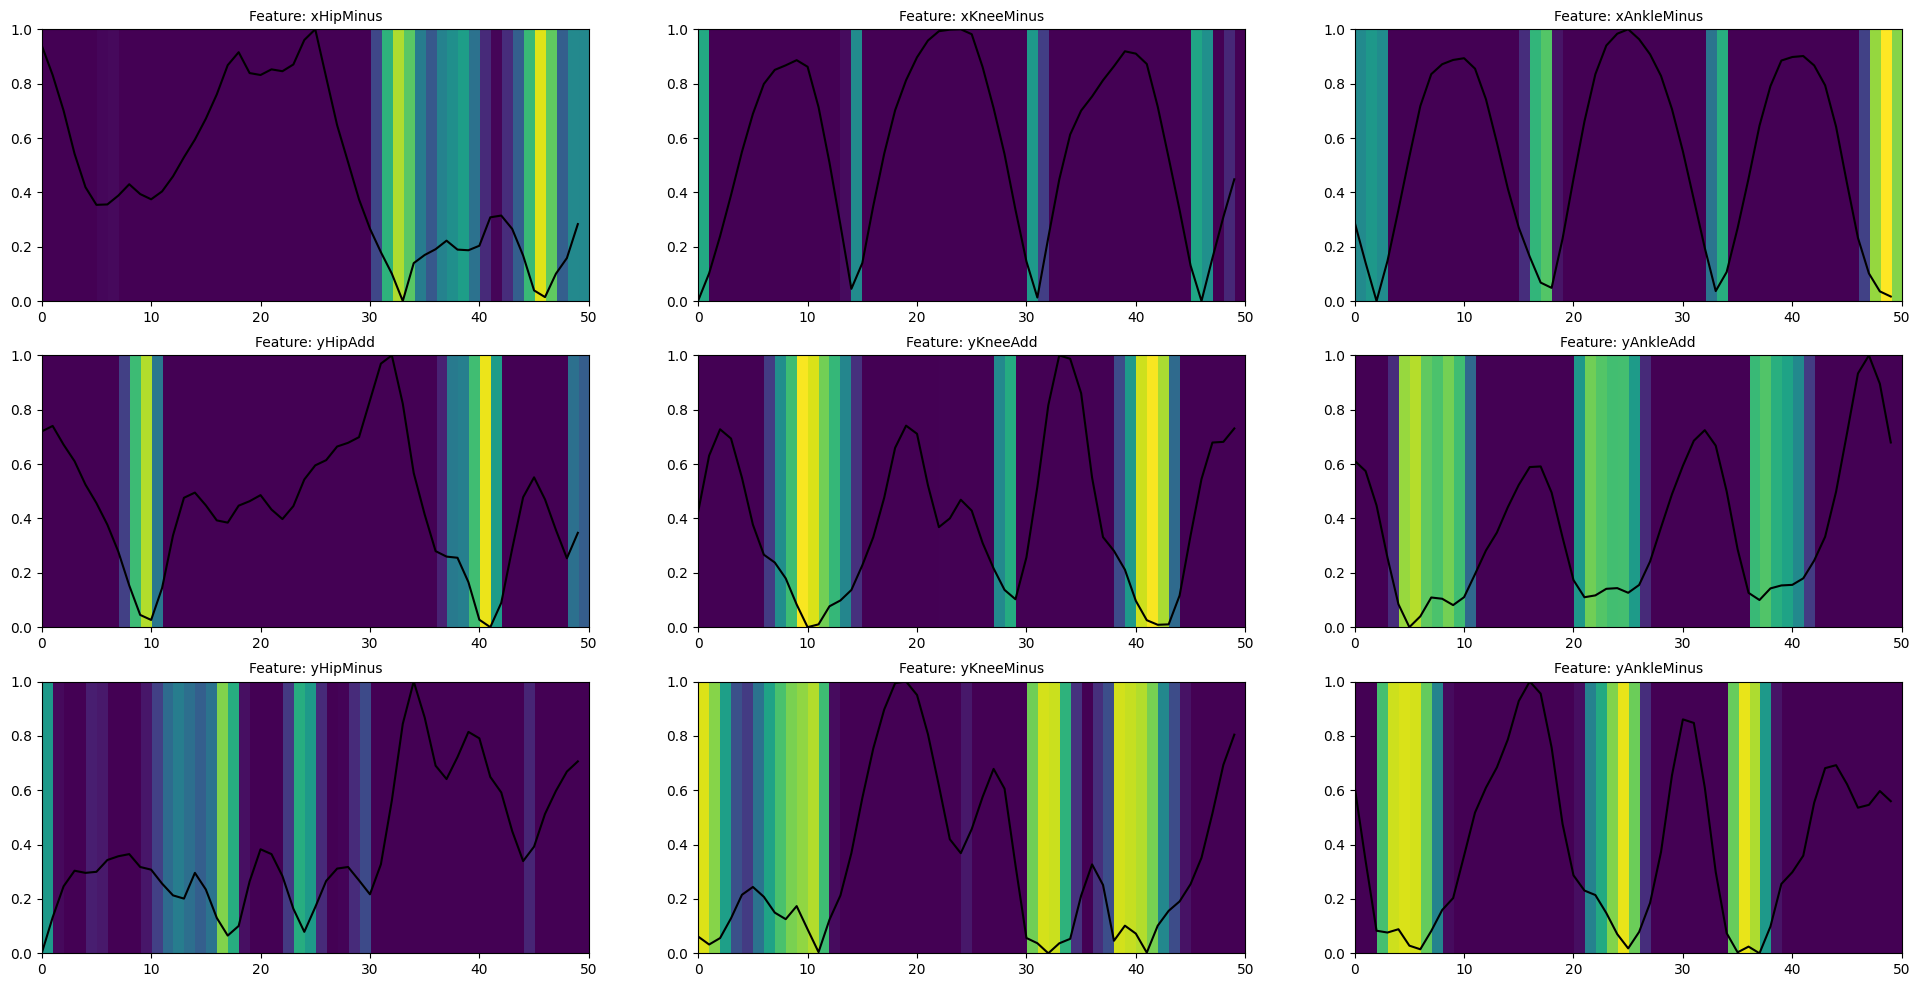

heatmap.shape = (9, 50)
------------------------------- [Pid 61] [Fold 1] Prob: 0.37689998745918274, Segment: 1, Video: cut1 -------------------------------
--------------------------------- Label: 1, Pred_average: 0, Pred_weighted: 1  ------------------------------


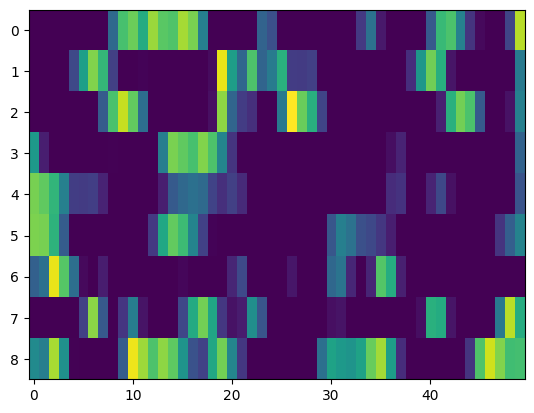

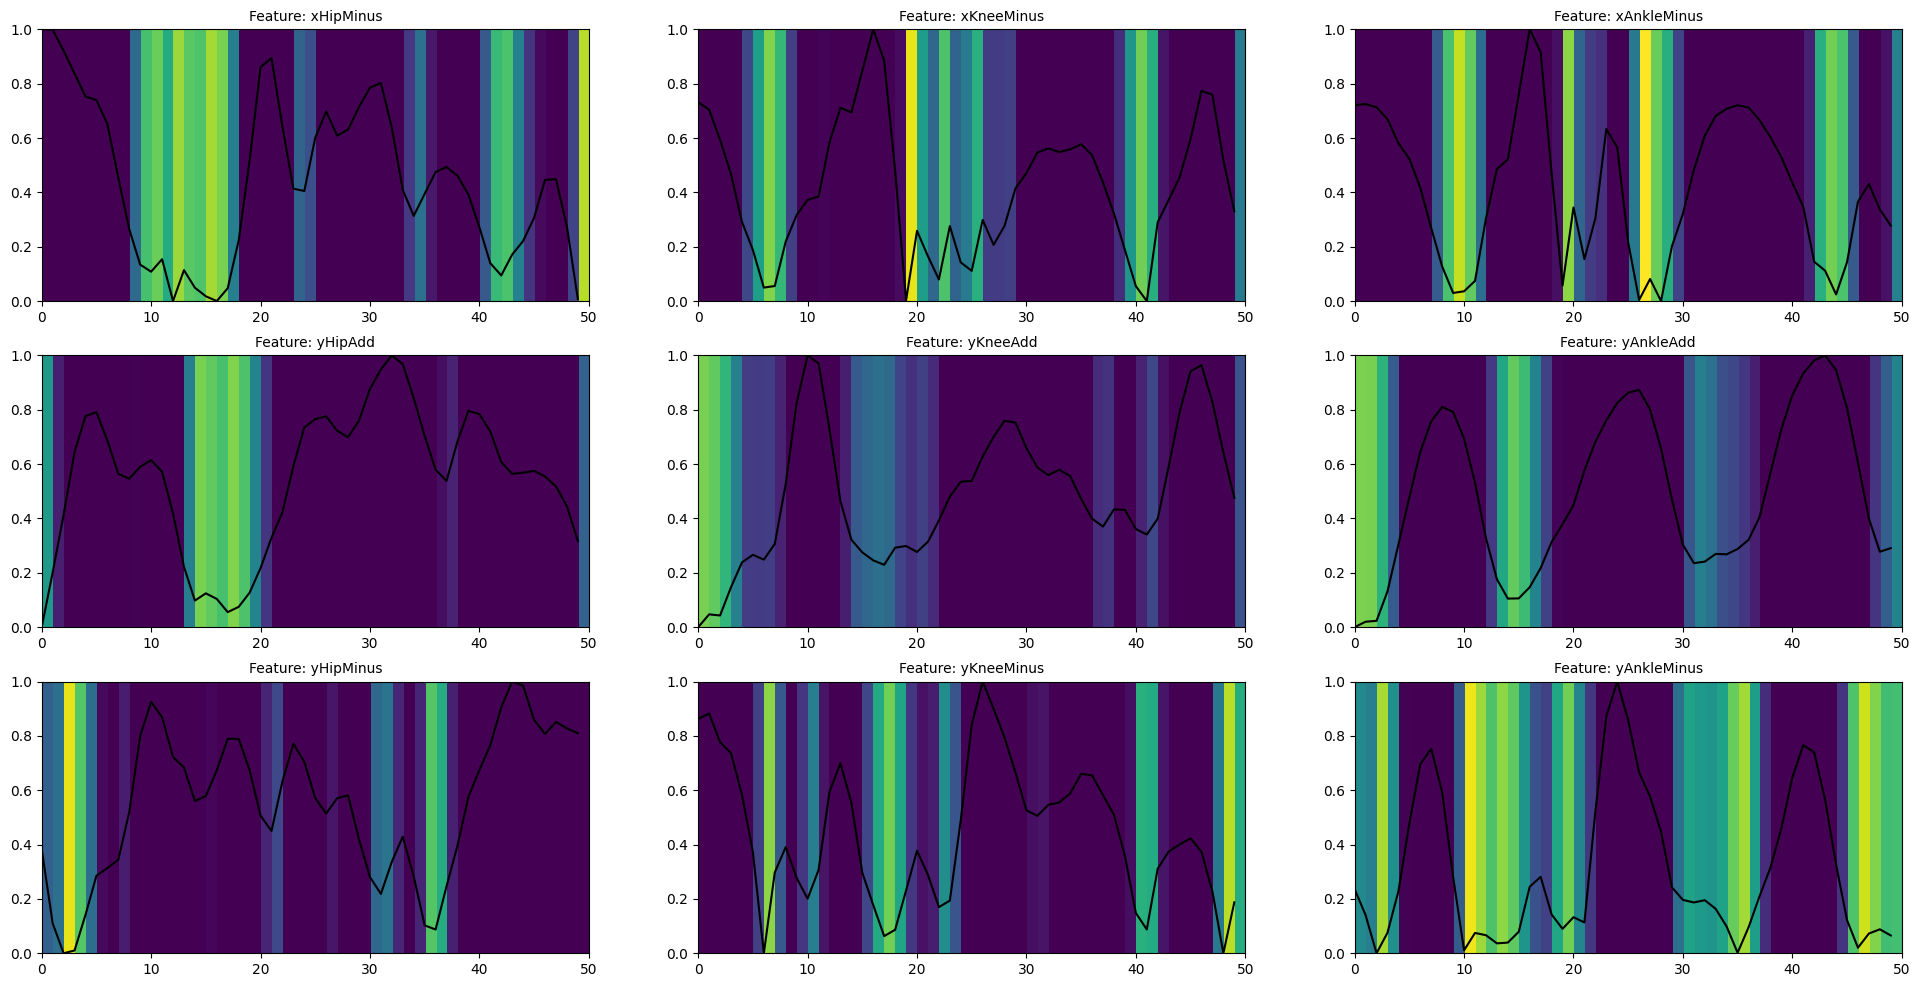

selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']


In [109]:
show_GradCAM_result_withoutResize()
# show_GradCAM_with_higher_confidence_withoutResize()

## Save Grad-CAM to CSV file

In [48]:
SAVE_SEGPROB_FOLDER = "LOG_FS/Segment_Probability/"

In [49]:
if not os.path.exists(SAVE_SEGPROB_FOLDER):
    os.makedirs(SAVE_SEGPROB_FOLDER)

def save_segemnt_probability_to_csv(prob_dict, file1, file2):
    prob_dict_sorted = {}
    myKeys = list(prob_dict.keys())
    myKeys.sort()
    prob_dict_sorted = {i: prob_dict[i] for i in myKeys}

    result_cut1_list = []
    result_cut2_list = []
    for pid in prob_dict_sorted:
        for seg in prob_dict_sorted[pid]:
            vtype = seg.split('_')[0]
            if vtype=='cut1':
                segName = str(pid) + '_segment_' + str(seg.split('_')[2])
                prob = prob_dict_sorted[pid][seg]
                result_cut1_list.append([segName, prob])
            elif vtype=='cut2M':
                segName = str(pid) + '_segment_' + str(seg.split('_')[2])
                prob = prob_dict_sorted[pid][seg]
                result_cut2_list.append([segName, prob])
                
    with open(file1, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerows(result_cut1_list)
    with open(file2, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerows(result_cut2_list)

save_segemnt_probability_to_csv(result_segment_dict, SAVE_SEGPROB_FOLDER+'seg_probability_cut1.csv', SAVE_SEGPROB_FOLDER+'seg_probability_cut2.csv')

In [50]:
SAVEGRADCAM_FOLDER = "LOG_FS/GradCAM_Explanations/"

if not os.path.exists(SAVEGRADCAM_FOLDER):
    os.makedirs(SAVEGRADCAM_FOLDER)

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def get_feature_name_list(selected_feature):
    new_feature_name_list = []
    
    feature_name_list = ['xHipAdd', 'xKneeAdd', 'xAnkleAdd', 'xHipMinus', 'xKneeMinus', 'xAnkleMinus', 
                         'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']
    
    for feat_idx in selected_feature:
        new_feature_name_list.append(feature_name_list[feat_idx])
    print(f'selected_feature: {selected_feature}')
    print(f'new_feature_name_list: {new_feature_name_list}')
    return new_feature_name_list


def save_GradCAM_to_CSV_file():
    feature_name_list = get_feature_name_list(selected_features)
    
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]

        for test_idx in range(len(idxTest_1f)):
            cur_pid = idxTest_1f[test_idx]
            segmentIdx = segmentIdx_1f[test_idx]
            videoIdx = videoIdx_1f[test_idx]

            label = Label_dict[int(cur_pid)]
            pred_average = result_dict[cur_pid]["prediction"]
            pred_weighted = result_weighted_dict[cur_pid]["prediction"]

            # if cur_pid==62:
            test_data = xTest_1f[test_idx]
            width, height = test_data.shape[1], test_data.shape[0]
            test_data = np.expand_dims(test_data, axis=0) ### shape=(1, 12, 50)

            filename = SAVEGRADCAM_FOLDER + str(cur_pid) + '_' + str(videoIdx) + '_Segment' + str(segmentIdx) + '.csv'  # "37_cut1_Segment1.csv"
            
            heatmap = make_gradcam_heatmap(test_data, model, 'last_conv')
            heatmap = np.uint8(255*heatmap)
            heatmap_df = pd.DataFrame(heatmap)
            heatmap_df.index = feature_name_list
            heatmap_df.to_csv(filename, header=False)

            # plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)                
            # plt.show()


save_GradCAM_to_CSV_file()

selected_feature: [3, 4, 5, 6, 7, 8, 9, 10, 11]
new_feature_name_list: ['xHipMinus', 'xKneeMinus', 'xAnkleMinus', 'yHipAdd', 'yKneeAdd', 'yAnkleAdd', 'yHipMinus', 'yKneeMinus', 'yAnkleMinus']


## Write to CSV file

In [33]:
def write_result_to_csv(data_dict, data_name, fileName):
    print(f'------ {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')

    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
        
    # field_name = ['pid', 'avgProb', 'prediction', 'actual']
    # with open(fileName, 'w', newline='') as f:
    #     write = csv.writer(f)
    #     write.writerow(field_name)
    #     write.writerows(result_list)
    return data_dict_sorted

In [34]:
result_csv_filename = "LOG_FS/Walking_RandomSeed_FS/Results/" + str(seed_value) + "_FS_average.csv"
result_dict_sorted = write_result_to_csv(result_dict, "result_dict", result_csv_filename)  #[RandomSeed]
result_dict_sorted

------ result_dict: -------

Number of subjects: 88 subjects.



{1: {'avegProb': 0.8953, 'n_pairs': 3, 'prediction': 1, 'actual': 0},
 2: {'avegProb': 0.4938, 'n_pairs': 2, 'prediction': 1, 'actual': 0},
 3: {'avegProb': 0.1667, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 4: {'avegProb': 0.9746, 'n_pairs': 5, 'prediction': 1, 'actual': 1},
 5: {'avegProb': 0.7063, 'n_pairs': 14, 'prediction': 1, 'actual': 0},
 6: {'avegProb': 0.9453, 'n_pairs': 3, 'prediction': 1, 'actual': 0},
 7: {'avegProb': 0.1146, 'n_pairs': 4, 'prediction': 0, 'actual': 0},
 9: {'avegProb': 0.6495, 'n_pairs': 10, 'prediction': 1, 'actual': 1},
 10: {'avegProb': 0.5902, 'n_pairs': 9, 'prediction': 1, 'actual': 1},
 11: {'avegProb': 0.7614, 'n_pairs': 9, 'prediction': 1, 'actual': 1},
 12: {'avegProb': 0.7125, 'n_pairs': 4, 'prediction': 1, 'actual': 1},
 13: {'avegProb': 0.8832, 'n_pairs': 8, 'prediction': 1, 'actual': 0},
 16: {'avegProb': 0.6687, 'n_pairs': 9, 'prediction': 1, 'actual': 1},
 17: {'avegProb': 0.7104, 'n_pairs': 6, 'prediction': 1, 'actual': 1},
 18: {'avegP

In [35]:
def write_weighted_result_to_csv(data_dict, data_name, fileName):
    print(f'------- {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')
    
    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb_weighted"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
    # field_name = ['pid', 'avgProb', 'prediction', 'actual']
    # with open(fileName, 'w', newline='') as f:
    #     write = csv.writer(f)
    #     write.writerow(field_name)
    #     write.writerows(result_list)
    return data_dict_sorted

In [36]:
result_csv_filename = "LOG_FS/Walking_RandomSeed_FS/Results/" + str(seed_value) + "_FS_weighted.csv"
result_weighted_dict_sorted = write_weighted_result_to_csv(result_weighted_dict, "result_weighted_dict", result_csv_filename)  #[RandomSeed]
result_weighted_dict_sorted

------- result_weighted_dict: -------

Number of subjects: 88 subjects.



{1: {'avegProb_weighted': 0.87, 'prediction': 1, 'actual': 0},
 2: {'avegProb_weighted': 0.0008, 'prediction': 0, 'actual': 0},
 3: {'avegProb_weighted': 0.083, 'prediction': 0, 'actual': 0},
 4: {'avegProb_weighted': 0.9764, 'prediction': 1, 'actual': 1},
 5: {'avegProb_weighted': 0.3738, 'prediction': 0, 'actual': 0},
 6: {'avegProb_weighted': 0.9429, 'prediction': 1, 'actual': 0},
 7: {'avegProb_weighted': 0.014, 'prediction': 0, 'actual': 0},
 9: {'avegProb_weighted': 0.7918, 'prediction': 1, 'actual': 1},
 10: {'avegProb_weighted': 0.9345, 'prediction': 1, 'actual': 1},
 11: {'avegProb_weighted': 0.9243, 'prediction': 1, 'actual': 1},
 12: {'avegProb_weighted': 0.7954, 'prediction': 1, 'actual': 1},
 13: {'avegProb_weighted': 0.834, 'prediction': 1, 'actual': 0},
 16: {'avegProb_weighted': 0.8524, 'prediction': 1, 'actual': 1},
 17: {'avegProb_weighted': 0.92, 'prediction': 1, 'actual': 1},
 18: {'avegProb_weighted': 0.7297, 'prediction': 1, 'actual': 1},
 19: {'avegProb_weighted'

# Metrics (5 folds)
* Accuracy
* Sensitivity
* Specificity
* Precision
* F1-Score
* AUC

In [37]:
best_threshold_5f_List = []
best_f1score_5f_List = []

LOAD_MODEL_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
LOAD_PARAMETER_FOLDER = "LOG_FS/Walking_RandomSeed_FS/" + str(seed_value) + "/Parameters/"

def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
    return threshold_list, f1score_list

best_threshold_5f_List, best_f1score_5f_List = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'best_threshold_5f_List:\n{best_threshold_5f_List}\n')
print(f'best_f1score_5f_List:\n{best_f1score_5f_List}')

best_threshold_5f_List:
[0.4, 0.5500000000000002, 0.42000000000000004, 0.45000000000000007, 0.4]

best_f1score_5f_List:
[0.5057471264367817, 0.5428571428571428, 0.5393258426966292, 0.5154639175257731, 0.48598130841121495]


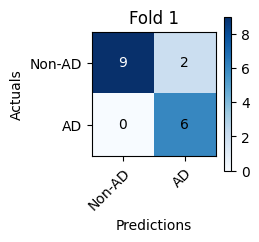

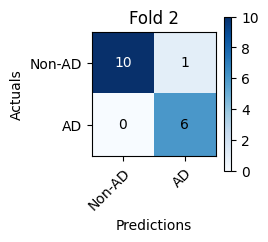

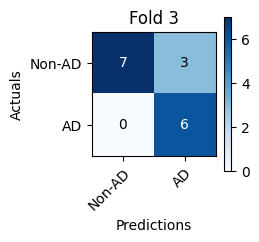

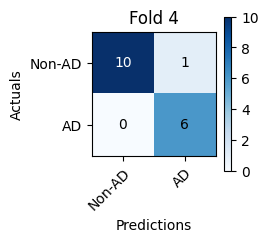

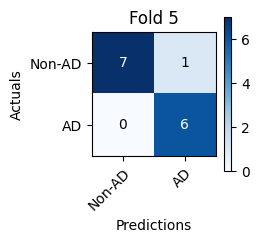

In [38]:
metrics_5fold_dict = {}

def load_model_and_evaluate_five_folds_metrics():
    metrics_5fold_dict = {}
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}walking_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], new_xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        videoIdx_1f = videoIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, n_SELECTED_FEATURE, int(n_PERIOD), 1)

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        auc = roc_auc_score(yTest_1f, yPred)
        
        metrics_5fold_dict[fold_idx] = {}
        metrics_5fold_dict[fold_idx]['AUC'] = round(auc, 4)
        
        predict_label_weighted_List = []
        actual_label_weighted_List = []
        
        uniqueID, countPair = np.unique(idxTest_1f, return_counts=True)
        for i in range(len(uniqueID)):
            pid = uniqueID[i]
            label = Label_dict[pid]
            
            prob_segments = []
            for j in range(len(idxTest_1f)):
                tmp_pid = idxTest_1f[j]
                if tmp_pid == pid:
                    prob_segments.append(round(yPred[j][0], 4))
            prob_segments = np.array(prob_segments)
            prob_weighted = 0
            if label==0:
                eps = sys.float_info.epsilon
                prob_segments = [w if w != 0 else eps for w in prob_segments]
                prob_segments = np.array(prob_segments)
                prob_weighted = np.average(prob_segments, weights=1/prob_segments)
            elif label==1:
                prob_weighted = np.average(prob_segments, weights=prob_segments)
                
            threshold = best_threshold_5f_List[fold_idx]
            if prob_weighted >= threshold: predict_label = 1
            else: predict_label = 0

            predict_label_weighted_List.append(predict_label)
            actual_label_weighted_List.append(label)
            
        predict_label_weighted_array = np.array(predict_label_weighted_List)
        actual_label_weighted_array = np.array(actual_label_weighted_List)
        matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
        TN, FP, FN, TP = matrix.ravel()
        value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
        value_sensitivity = round(TP/(TP+FN), 4)
        value_specificity = round(TN/(TN+FP), 4)
        value_precision = round(TP/(TP+FP), 4)
        value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
        
        classList = ['Non-AD', 'AD']
        matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
        TN, FP, FN, TP = matrix.ravel()
        fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(2, 2), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
        plt.xlabel('Predictions', fontsize=10)
        plt.ylabel('Actuals', fontsize=10)
        plt.title(f'Fold {fold_idx+1}', fontsize=12)
        plt.show()
        
        metrics_5fold_dict[fold_idx]['Accuracy'] = value_accuracy
        metrics_5fold_dict[fold_idx]['Sensitivity'] = value_sensitivity
        metrics_5fold_dict[fold_idx]['Specificity'] = value_specificity
        metrics_5fold_dict[fold_idx]['Precision'] = value_precision
        metrics_5fold_dict[fold_idx]['F1-Score'] = value_f1_score
    return metrics_5fold_dict


metrics_5fold_dict = load_model_and_evaluate_five_folds_metrics()

In [39]:
acc_5f, auc_5f, sen_5f, spe_5f, pre_5f, f1_5f = [], [], [], [], [], []
for fold_idx in range(n_FOLD):
    one_fold_metrics = metrics_5fold_dict[fold_idx]
    acc = one_fold_metrics['Accuracy']
    auc = one_fold_metrics['AUC']
    sen = one_fold_metrics['Sensitivity']
    spe = one_fold_metrics['Specificity']
    pre = one_fold_metrics['Precision']
    f1score = one_fold_metrics['F1-Score']
    print(f'[Fold {fold_idx+1}] Accuracy: {acc}, Sensitivity: {sen}, Specificity: {spe}, Precision: {pre}, F1-score: {f1score}, AUC: {auc}')
    
    acc_5f.append(round(acc*100, 2))
    auc_5f.append(auc)
    sen_5f.append(round(sen*100, 2))
    spe_5f.append(round(spe*100, 2))
    pre_5f.append(round(pre*100, 2))
    f1_5f.append(f1score)

[Fold 1] Accuracy: 0.8824, Sensitivity: 1.0, Specificity: 0.8182, Precision: 0.75, F1-score: 0.86, AUC: 0.6698
[Fold 2] Accuracy: 0.9412, Sensitivity: 1.0, Specificity: 0.9091, Precision: 0.8571, F1-score: 0.92, AUC: 0.5934
[Fold 3] Accuracy: 0.8125, Sensitivity: 1.0, Specificity: 0.7, Precision: 0.6667, F1-score: 0.8, AUC: 0.5278
[Fold 4] Accuracy: 0.9412, Sensitivity: 1.0, Specificity: 0.9091, Precision: 0.8571, F1-score: 0.92, AUC: 0.722
[Fold 5] Accuracy: 0.9286, Sensitivity: 1.0, Specificity: 0.875, Precision: 0.8571, F1-score: 0.92, AUC: 0.7948


In [40]:
from scipy import stats
import statistics

print(f'Accuracy    ({len(acc_5f)}), mean({round(statistics.mean(acc_5f), 2)}), std({round(statistics.pstdev(acc_5f), 2)}): {acc_5f}')
print(f'Sensitivity ({len(sen_5f)}), mean({round(statistics.mean(sen_5f), 2)}), std({round(statistics.pstdev(sen_5f), 2)}): {sen_5f}')
print(f'Specificity ({len(spe_5f)}), mean({round(statistics.mean(spe_5f), 2)}), std({round(statistics.pstdev(spe_5f), 2)}): {spe_5f}')
print(f'Precision   ({len(pre_5f)}), mean({round(statistics.mean(pre_5f), 2)}), std({round(statistics.pstdev(pre_5f), 2)}): {pre_5f}')
print(f'F1-Score    ({len(f1_5f)}), mean({round(statistics.mean(f1_5f), 2)}), std({round(statistics.pstdev(f1_5f), 2)}): {f1_5f}')
print(f'AUC         ({len(auc_5f)}), mean({round(statistics.mean(auc_5f), 2)}), std({round(statistics.pstdev(auc_5f), 2)}): {auc_5f}')

Accuracy    (5), mean(90.12), std(4.93): [88.24, 94.12, 81.25, 94.12, 92.86]
Sensitivity (5), mean(100.0), std(0.0): [100.0, 100.0, 100.0, 100.0, 100.0]
Specificity (5), mean(84.23), std(7.85): [81.82, 90.91, 70.0, 90.91, 87.5]
Precision   (5), mean(79.76), std(7.75): [75.0, 85.71, 66.67, 85.71, 85.71]
F1-Score    (5), mean(0.88), std(0.05): [0.86, 0.92, 0.8, 0.92, 0.92]
AUC         (5), mean(0.66), std(0.09): [0.6698, 0.5934, 0.5278, 0.722, 0.7948]


# Tracks

In [37]:
import operator

In [38]:
CN_score_dict = {}

CN_average_result_list = []
CN_average_confidence_list = []
CN_average_probability_list = []

CN_weighted_result_list = []
CN_weighted_confidence_list = []
CN_weighted_probability_list = []


for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_dict_sorted[pid]['avegProb']
        prediction = result_dict_sorted[pid]['prediction']
        actual = result_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==0 and prediction==actual:
            CN_average_result_list.append([pid, prob, conf])
            
CN_average_confidence_list = sorted(CN_average_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
CN_average_probability_list = sorted(CN_average_result_list, key=operator.itemgetter(1)) ### Probability



for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
        prediction = result_weighted_dict_sorted[pid]['prediction']
        actual = result_weighted_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==0 and prediction==actual:
            CN_weighted_result_list.append([pid, prob, conf])
            
CN_weighted_confidence_list = sorted(CN_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
CN_weighted_probability_list = sorted(CN_weighted_result_list, key=operator.itemgetter(1)) ### Probability



# for i, data in enumerate(CN_average_confidence_list):
#     pid = data[0]
#     if pid not in CN_score_dict: CN_score_dict[pid] = 0
#     CN_score_dict[pid] += i

for i, data in enumerate(CN_average_probability_list):
    pid = data[0]
    if pid not in CN_score_dict: CN_score_dict[pid] = 0
    CN_score_dict[pid] += i

# for i, data in enumerate(CN_weighted_confidence_list):
#     pid = data[0]
#     if pid not in CN_score_dict: CN_score_dict[pid] = 0
#     CN_score_dict[pid] += i


for i, data in enumerate(CN_weighted_probability_list):
    pid = data[0]
    if pid not in CN_score_dict: CN_score_dict[pid] = 0
    CN_score_dict[pid] += i


CN_score_dict
CN_score_dict_by_score = sorted(CN_score_dict.items(), key=lambda x:x[1])
print(f'Number of Subjects: {len(CN_score_dict_by_score)}')
CN_score_dict_by_score


Number of Subjects: 51


[(2, 2),
 (30, 9),
 (78, 9),
 (79, 10),
 (29, 12),
 (81, 14),
 (93, 17),
 (89, 18),
 (75, 19),
 (7, 20),
 (19, 21),
 (95, 22),
 (66, 24),
 (90, 25),
 (70, 25),
 (76, 27),
 (71, 27),
 (99, 27),
 (77, 27),
 (97, 28),
 (100, 28),
 (44, 28),
 (34, 28),
 (88, 31),
 (43, 33),
 (74, 34),
 (58, 35),
 (51, 42),
 (83, 43),
 (92, 44),
 (96, 44),
 (84, 44),
 (73, 45),
 (49, 45),
 (80, 46),
 (98, 46),
 (69, 47),
 (3, 48),
 (21, 48),
 (87, 49),
 (5, 49),
 (72, 50),
 (91, 55),
 (85, 55),
 (33, 60),
 (57, 63),
 (52, 63),
 (63, 68),
 (68, 68),
 (64, 70),
 (22, 78)]

In [52]:
AD_score_dict = {}

AD_average_result_list = []
AD_average_confidence_list = []
AD_average_probability_list = []

AD_weighted_result_list = []
AD_weighted_confidence_list = []
AD_weighted_probability_list = []


for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_dict_sorted[pid]['avegProb']
        prediction = result_dict_sorted[pid]['prediction']
        actual = result_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==1 and prediction==actual:
            AD_average_result_list.append([pid, prob, conf])
            
AD_average_confidence_list = sorted(AD_average_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
AD_average_probability_list = sorted(AD_average_result_list, key=operator.itemgetter(1), reverse=True) ### Probability


for foldIdx in range(n_FOLD):
    testID = testID_5f[foldIdx]
    tmp_threshold = best_threshold_5f_List[foldIdx]
    
    for pid in testID:
        pid = int(pid)
        prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
        prediction = result_weighted_dict_sorted[pid]['prediction']
        actual = result_weighted_dict_sorted[pid]['actual']
        conf = round(abs(tmp_threshold-prob), 2)
        
        if prediction==1 and prediction==actual:
            AD_weighted_result_list.append([pid, prob, conf])
            
AD_weighted_confidence_list = sorted(AD_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
AD_weighted_probability_list = sorted(AD_weighted_result_list, key=operator.itemgetter(1), reverse=True) ### Probability



# for i, data in enumerate(AD_average_confidence_list):
#     pid = data[0]
#     if pid not in AD_score_dict: AD_score_dict[pid] = 0
#     AD_score_dict[pid] += i

for i, data in enumerate(AD_average_probability_list):
    pid = data[0]
    if pid not in AD_score_dict: AD_score_dict[pid] = 0
    AD_score_dict[pid] += i

# for i, data in enumerate(AD_weighted_confidence_list):
#     pid = data[0]
#     if pid not in AD_score_dict: AD_score_dict[pid] = 0
#     AD_score_dict[pid] += i

for i, data in enumerate(AD_weighted_probability_list):
    pid = data[0]
    if pid not in AD_score_dict: AD_score_dict[pid] = 0
    AD_score_dict[pid] += i


AD_score_dict
AD_score_dict_by_score = sorted(AD_score_dict.items(), key=lambda x:x[1])
print(f'Number of Subjects: {len(AD_score_dict_by_score)}')
AD_score_dict_by_score



Number of Subjects: 29


[(4, 0),
 (28, 3),
 (35, 5),
 (65, 5),
 (59, 8),
 (11, 10),
 (38, 16),
 (62, 17),
 (26, 18),
 (17, 18),
 (61, 21),
 (10, 22),
 (36, 23),
 (27, 23),
 (39, 24),
 (20, 26),
 (12, 27),
 (31, 27),
 (16, 28),
 (37, 28),
 (25, 29),
 (32, 32),
 (9, 34),
 (45, 37),
 (60, 40),
 (24, 44),
 (18, 45),
 (46, 45),
 (48, 51)]

In [40]:
CN_average_confidence_list


[[76, 0.0387, 0.36],
 [71, 0.052, 0.35],
 [30, 0.0549, 0.35],
 [58, 0.0778, 0.35],
 [77, 0.094, 0.34],
 [92, 0.0989, 0.33],
 [99, 0.0826, 0.32],
 [7, 0.1146, 0.32],
 [91, 0.203, 0.31],
 [97, 0.1187, 0.28],
 [95, 0.1175, 0.28],
 [88, 0.1547, 0.28],
 [81, 0.1297, 0.27],
 [89, 0.1689, 0.23],
 [3, 0.1667, 0.23],
 [73, 0.2073, 0.22],
 [90, 0.3106, 0.2],
 [85, 0.2077, 0.19],
 [70, 0.3426, 0.17],
 [43, 0.349, 0.16],
 [96, 0.347, 0.16],
 [100, 0.2447, 0.16],
 [69, 0.2646, 0.14],
 [52, 0.3915, 0.12],
 [80, 0.3065, 0.12],
 [75, 0.2925, 0.11],
 [44, 0.2951, 0.1],
 [87, 0.4182, 0.09],
 [64, 0.3363, 0.09],
 [63, 0.3616, 0.07],
 [33, 0.3461, 0.05],
 [49, 0.3637, 0.04],
 [57, 0.3834, 0.02],
 [68, 0.3847, 0.02],
 [22, 0.4162, 0.01]]

In [41]:
CN_average_probability_list


[[76, 0.0387, 0.36],
 [71, 0.052, 0.35],
 [30, 0.0549, 0.35],
 [58, 0.0778, 0.35],
 [99, 0.0826, 0.32],
 [77, 0.094, 0.34],
 [92, 0.0989, 0.33],
 [7, 0.1146, 0.32],
 [95, 0.1175, 0.28],
 [97, 0.1187, 0.28],
 [81, 0.1297, 0.27],
 [88, 0.1547, 0.28],
 [3, 0.1667, 0.23],
 [89, 0.1689, 0.23],
 [91, 0.203, 0.31],
 [73, 0.2073, 0.22],
 [85, 0.2077, 0.19],
 [100, 0.2447, 0.16],
 [69, 0.2646, 0.14],
 [75, 0.2925, 0.11],
 [44, 0.2951, 0.1],
 [80, 0.3065, 0.12],
 [90, 0.3106, 0.2],
 [64, 0.3363, 0.09],
 [70, 0.3426, 0.17],
 [33, 0.3461, 0.05],
 [96, 0.347, 0.16],
 [43, 0.349, 0.16],
 [63, 0.3616, 0.07],
 [49, 0.3637, 0.04],
 [57, 0.3834, 0.02],
 [68, 0.3847, 0.02],
 [52, 0.3915, 0.12],
 [22, 0.4162, 0.01],
 [87, 0.4182, 0.09]]

In [42]:
CN_weighted_confidence_list


[[43, 0.0038, 0.51],
 [70, 0.0, 0.51],
 [90, 0.0027, 0.51],
 [87, 0.0164, 0.49],
 [93, 0.0181, 0.49],
 [96, 0.0206, 0.49],
 [66, 0.0298, 0.48],
 [52, 0.0682, 0.44],
 [91, 0.0926, 0.42],
 [7, 0.014, 0.42],
 [88, 0.0216, 0.41],
 [2, 0.0008, 0.4],
 [75, 0.0, 0.4],
 [81, 0.0033, 0.4],
 [89, 0.0033, 0.4],
 [30, 0.0049, 0.4],
 [77, 0.0253, 0.4],
 [80, 0.0307, 0.4],
 [29, 0.0136, 0.39],
 [44, 0.0087, 0.39],
 [79, 0.0119, 0.39],
 [100, 0.0127, 0.39],
 [78, 0.0087, 0.39],
 [95, 0.0143, 0.39],
 [49, 0.017, 0.38],
 [97, 0.0207, 0.38],
 [19, 0.0231, 0.38],
 [73, 0.0495, 0.38],
 [71, 0.0308, 0.37],
 [76, 0.0342, 0.37],
 [99, 0.0283, 0.37],
 [34, 0.0392, 0.36],
 [58, 0.0744, 0.36],
 [69, 0.0487, 0.35],
 [63, 0.0916, 0.34],
 [92, 0.0899, 0.34],
 [3, 0.083, 0.32],
 [33, 0.0817, 0.32],
 [57, 0.0795, 0.32],
 [74, 0.0814, 0.32],
 [68, 0.0883, 0.31],
 [85, 0.0904, 0.31],
 [51, 0.1872, 0.21],
 [83, 0.2434, 0.16],
 [22, 0.2684, 0.16],
 [21, 0.3602, 0.15],
 [84, 0.2459, 0.15],
 [5, 0.3738, 0.14],
 [98, 0.319

In [43]:
CN_weighted_probability_list

[[75, 0.0, 0.4],
 [70, 0.0, 0.51],
 [2, 0.0008, 0.4],
 [90, 0.0027, 0.51],
 [81, 0.0033, 0.4],
 [89, 0.0033, 0.4],
 [43, 0.0038, 0.51],
 [30, 0.0049, 0.4],
 [44, 0.0087, 0.39],
 [78, 0.0087, 0.39],
 [79, 0.0119, 0.39],
 [100, 0.0127, 0.39],
 [29, 0.0136, 0.39],
 [7, 0.014, 0.42],
 [95, 0.0143, 0.39],
 [87, 0.0164, 0.49],
 [49, 0.017, 0.38],
 [93, 0.0181, 0.49],
 [96, 0.0206, 0.49],
 [97, 0.0207, 0.38],
 [88, 0.0216, 0.41],
 [19, 0.0231, 0.38],
 [77, 0.0253, 0.4],
 [99, 0.0283, 0.37],
 [66, 0.0298, 0.48],
 [80, 0.0307, 0.4],
 [71, 0.0308, 0.37],
 [76, 0.0342, 0.37],
 [34, 0.0392, 0.36],
 [69, 0.0487, 0.35],
 [73, 0.0495, 0.38],
 [52, 0.0682, 0.44],
 [58, 0.0744, 0.36],
 [57, 0.0795, 0.32],
 [74, 0.0814, 0.32],
 [33, 0.0817, 0.32],
 [3, 0.083, 0.32],
 [68, 0.0883, 0.31],
 [92, 0.0899, 0.34],
 [85, 0.0904, 0.31],
 [63, 0.0916, 0.34],
 [91, 0.0926, 0.42],
 [51, 0.1872, 0.21],
 [83, 0.2434, 0.16],
 [84, 0.2459, 0.15],
 [22, 0.2684, 0.16],
 [98, 0.319, 0.11],
 [64, 0.331, 0.1],
 [21, 0.3602,

In [53]:
AD_average_confidence_list


[[4, 0.9746, 0.57],
 [28, 0.9289, 0.53],
 [26, 0.7818, 0.38],
 [11, 0.7614, 0.36],
 [59, 0.7129, 0.31],
 [38, 0.715, 0.31],
 [31, 0.7009, 0.3],
 [35, 0.7936, 0.28],
 [17, 0.7104, 0.28],
 [16, 0.6687, 0.27],
 [25, 0.689, 0.26],
 [36, 0.6163, 0.22],
 [9, 0.6495, 0.22],
 [39, 0.6502, 0.22],
 [62, 0.7158, 0.21],
 [60, 0.6053, 0.21],
 [27, 0.6063, 0.21],
 [12, 0.7125, 0.2],
 [32, 0.5331, 0.13],
 [46, 0.4966, 0.1],
 [10, 0.5902, 0.08],
 [18, 0.4975, 0.07],
 [24, 0.4844, 0.05],
 [45, 0.4372, 0.04],
 [48, 0.4076, 0.01]]

In [54]:
AD_average_probability_list


[[4, 0.9746, 0.57],
 [28, 0.9289, 0.53],
 [35, 0.7936, 0.28],
 [26, 0.7818, 0.38],
 [11, 0.7614, 0.36],
 [62, 0.7158, 0.21],
 [38, 0.715, 0.31],
 [59, 0.7129, 0.31],
 [12, 0.7125, 0.2],
 [17, 0.7104, 0.28],
 [31, 0.7009, 0.3],
 [25, 0.689, 0.26],
 [16, 0.6687, 0.27],
 [39, 0.6502, 0.22],
 [9, 0.6495, 0.22],
 [36, 0.6163, 0.22],
 [27, 0.6063, 0.21],
 [60, 0.6053, 0.21],
 [10, 0.5902, 0.08],
 [32, 0.5331, 0.13],
 [18, 0.4975, 0.07],
 [46, 0.4966, 0.1],
 [24, 0.4844, 0.05],
 [45, 0.4372, 0.04],
 [48, 0.4076, 0.01]]

In [55]:
AD_weighted_confidence_list


[[4, 0.9764, 0.58],
 [59, 0.9629, 0.56],
 [28, 0.9421, 0.54],
 [11, 0.9243, 0.52],
 [36, 0.921, 0.52],
 [27, 0.9227, 0.52],
 [38, 0.9181, 0.52],
 [17, 0.92, 0.49],
 [32, 0.8691, 0.47],
 [39, 0.9003, 0.47],
 [45, 0.8616, 0.46],
 [16, 0.8524, 0.45],
 [26, 0.8534, 0.45],
 [35, 0.9407, 0.43],
 [31, 0.835, 0.43],
 [10, 0.9345, 0.42],
 [65, 0.9288, 0.42],
 [60, 0.7705, 0.37],
 [25, 0.8048, 0.37],
 [62, 0.8715, 0.36],
 [46, 0.756, 0.36],
 [9, 0.7918, 0.36],
 [24, 0.7795, 0.35],
 [18, 0.7297, 0.3],
 [12, 0.7954, 0.29],
 [61, 0.7834, 0.27],
 [20, 0.628, 0.23],
 [48, 0.6093, 0.21],
 [37, 0.5808, 0.18]]

In [56]:
AD_weighted_probability_list

[[4, 0.9764, 0.58],
 [59, 0.9629, 0.56],
 [28, 0.9421, 0.54],
 [35, 0.9407, 0.43],
 [10, 0.9345, 0.42],
 [65, 0.9288, 0.42],
 [11, 0.9243, 0.52],
 [27, 0.9227, 0.52],
 [36, 0.921, 0.52],
 [17, 0.92, 0.49],
 [38, 0.9181, 0.52],
 [39, 0.9003, 0.47],
 [62, 0.8715, 0.36],
 [32, 0.8691, 0.47],
 [45, 0.8616, 0.46],
 [26, 0.8534, 0.45],
 [16, 0.8524, 0.45],
 [31, 0.835, 0.43],
 [25, 0.8048, 0.37],
 [12, 0.7954, 0.29],
 [9, 0.7918, 0.36],
 [61, 0.7834, 0.27],
 [24, 0.7795, 0.35],
 [60, 0.7705, 0.37],
 [46, 0.756, 0.36],
 [18, 0.7297, 0.3],
 [20, 0.628, 0.23],
 [48, 0.6093, 0.21],
 [37, 0.5808, 0.18]]

In [101]:
# CN_weighted_result_list = []


# for foldIdx in range(n_FOLD):
#     testID = testID_5f[foldIdx]
#     tmp_threshold = best_threshold_5f_List[foldIdx]
    
#     for pid in testID:
#         pid = int(pid)
#         prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
#         prediction = result_weighted_dict_sorted[pid]['prediction']
#         actual = result_weighted_dict_sorted[pid]['actual']
#         conf = round(abs(tmp_threshold-prob), 2)
        
#         if prediction==0 and prediction==actual:
#             CN_weighted_result_list.append([pid, prob, conf])
            
# CN_weighted_result_list = sorted(CN_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
# # CN_weighted_result_list = sorted(CN_weighted_result_list, key=operator.itemgetter(1)) ### Probability
# CN_weighted_result_list

In [100]:
# AD_weighted_result_list = []

# for foldIdx in range(n_FOLD):
#     testID = testID_5f[foldIdx]
#     tmp_threshold = best_threshold_5f_List[foldIdx]
    
#     for pid in testID:
#         pid = int(pid)
#         prob = result_weighted_dict_sorted[pid]['avegProb_weighted']
#         prediction = result_weighted_dict_sorted[pid]['prediction']
#         actual = result_weighted_dict_sorted[pid]['actual']
#         conf = round(abs(tmp_threshold-prob), 2)
        
#         if prediction==1 and prediction==actual:
#             AD_weighted_result_list.append([pid, prob, conf])
            
# # AD_weighted_result_list = sorted(AD_weighted_result_list, key=operator.itemgetter(2), reverse=True) ### Confidence
# AD_weighted_result_list = sorted(AD_weighted_result_list, key=operator.itemgetter(1), reverse=True) ### Probability
# AD_weighted_result_list

# AD-Label vs. Age-Label

In [24]:
AD_Label_file = "../Label_Data_Info.xlsx"
AD_prediction_file = "LOG_FS/Walking_RandomSeed_FS/Results/10_FS_weighted.csv"

Age_Label_file = "../Label_Data_Info.xlsx"   # Mean (66 years old)
Age_prediction_file = "LOG_Age/20240613_FS_weighted.csv"

AD_Label_dict = {}
AD_prediction_dict = {}
Age_Label_dict = {}
Age_prediction_dict = {}

Age_file = "../Label_Data_Info.xlsx"
Age_dict = {}

In [25]:
def read_age_from_csv_file(filename):
    tmp_dict = {}
    df_label = pd.read_excel(filename, usecols=['編號', 'Age'])
    df_label = df_label.fillna(0)
    df_label = df_label.astype({"Age": int})
    
    Label_df = df_label['Age']
    Label_arr = np.array(Label_df)
    tmp_dict = dict(zip(df_label.編號, df_label.Age))
    return tmp_dict

def read_label_from_csv_file(filename):
    tmp_dict = {}
    df_label = pd.read_excel(filename, usecols=['編號', '_Label'])
    df_label = df_label.fillna(0)
    df_label = df_label.astype({"_Label": int})
    
    Label_df = df_label['_Label']
    Label_arr = np.array(Label_df)
    tmp_dict = dict(zip(df_label.編號, df_label._Label))
    return tmp_dict

def read_age_label_from_csv_file(filename):
    tmp_dict = {}
    df_label = pd.read_excel(filename, usecols=['編號', 'Label_66'])
    df_label = df_label.fillna(0)
    df_label = df_label.astype({"Label_66": int})
    
    Label_df = df_label['Label_66']
    Label_arr = np.array(Label_df)
    tmp_dict = dict(zip(df_label.編號, df_label.Label_66))
    return tmp_dict

def read_prediction_from_csv_file(filename):
    if not os.path.exists(filename):
        print(filename)
        print(f'Prediction CSV File does not exist.')
    else:
        tmp_dict = {}
        df = pd.read_csv(filename)
        for idx in df.index:
            pid = df['pid'].loc[df.index[idx]]
            prediction = df['prediction'].loc[df.index[idx]]
            tmp_dict[pid] = prediction
    return tmp_dict


Age_dict = read_age_from_csv_file(Age_file)

AD_Label_dict = read_label_from_csv_file(AD_Label_file)
Age_Label_dict = read_age_label_from_csv_file(Age_Label_file)

AD_prediction_dict = read_prediction_from_csv_file(AD_prediction_file)
Age_prediction_dict = read_prediction_from_csv_file(Age_prediction_file)

In [26]:
print(f'[Pid 1] age: {Age_dict[1]}')
print(f'[Pid 1] AD-Label:  {AD_Label_dict[1]}, AD-Prediction: {AD_prediction_dict[1]}')
print(f'[Pid 1] Age-Label: {Age_Label_dict[1]}, Age-Prediction: {Age_prediction_dict[1]}')

[Pid 1] age: 40
[Pid 1] AD-Label:  0, AD-Prediction: 1
[Pid 1] Age-Label: 0, Age-Prediction: 1


In [27]:
def check_label_change_performance(pidList):
    CN_to_AD = 0
    CN_to_CN = 0
    AD_to_AD = 0
    
    CN_to_AD_age, CN_to_AD_pid = [], []
    CN_to_CN_age, CN_to_CN_pid = [], []
    AD_to_AD_age, AD_to_AD_pid = [], []
    
    for pid in pidList:
        pid = int(pid)
        age = Age_dict[pid]
        original_label = AD_Label_dict[pid]
        original_pred = AD_prediction_dict[pid]
        new_label = Age_Label_dict[pid]
        new_pred = Age_prediction_dict[pid]

        if original_label!=new_label:
            print(f'[Pid {pid}] Age: {age},  Label: ({original_label}->{new_label}), Pred: ({original_pred}->{new_pred})')
            if original_pred==0 and new_pred==1: 
                CN_to_AD += 1
                CN_to_AD_age.append(age)
                CN_to_AD_pid.append(pid)
            if original_pred==0 and new_pred==0: 
                CN_to_CN += 1
                CN_to_CN_age.append(age)
                CN_to_CN_pid.append(pid)
            if original_pred==1 and new_pred==1: 
                AD_to_AD += 1
                AD_to_AD_age.append(age)
                AD_to_AD_pid.append(pid)
    
    CN_to_AD_age.sort()
    CN_to_CN_age.sort()
    AD_to_AD_age.sort()
    print(f'\n CN->AD: {CN_to_AD} subjects: {CN_to_AD_age}')
    print(f'  1) Age: {CN_to_AD_age}')
    print(f'  2) Pid: {CN_to_AD_pid}')
    
    print(f' CN->CN: {CN_to_CN} subjects:  {CN_to_CN_age}')
    print(f'  1) Age: {CN_to_CN_age}')
    print(f'  2) Pid: {CN_to_CN_pid}')
    
    print(f' AD->AD: {AD_to_AD} subjects:  {AD_to_AD_age}')
    print(f'  1) Age: {AD_to_AD_age}')
    print(f'  2) Pid: {AD_to_AD_pid}')
    
check_label_change_performance(allID)

[Pid 5] Age: 75,  Label: (0->1), Pred: (0->1)
[Pid 6] Age: 80,  Label: (0->1), Pred: (1->1)
[Pid 100] Age: 68,  Label: (0->1), Pred: (0->1)
[Pid 13] Age: 75,  Label: (0->1), Pred: (1->1)
[Pid 19] Age: 75,  Label: (0->1), Pred: (0->1)
[Pid 21] Age: 74,  Label: (0->1), Pred: (0->1)
[Pid 30] Age: 67,  Label: (0->1), Pred: (0->0)
[Pid 34] Age: 69,  Label: (0->1), Pred: (0->1)
[Pid 43] Age: 72,  Label: (0->1), Pred: (0->1)
[Pid 44] Age: 96,  Label: (0->1), Pred: (0->1)
[Pid 49] Age: 78,  Label: (0->1), Pred: (0->1)
[Pid 51] Age: 70,  Label: (0->1), Pred: (0->1)
[Pid 52] Age: 75,  Label: (0->1), Pred: (0->1)
[Pid 63] Age: 66,  Label: (0->1), Pred: (1->1)
[Pid 68] Age: 72,  Label: (0->1), Pred: (0->1)
[Pid 77] Age: 68,  Label: (0->1), Pred: (0->1)
[Pid 78] Age: 69,  Label: (0->1), Pred: (0->1)
[Pid 79] Age: 68,  Label: (0->1), Pred: (0->1)
[Pid 81] Age: 69,  Label: (0->1), Pred: (0->0)
[Pid 83] Age: 73,  Label: (0->1), Pred: (0->1)
[Pid 84] Age: 68,  Label: (0->1), Pred: (0->1)
[Pid 85] Age: 

In [75]:
# def check_prediction_change_performance(pidList):
#     CN_to_AD = 0
#     CN_to_CN = 0
#     AD_to_AD = 0
    
#     CN_to_AD_age, CN_to_AD_pid = [], []
#     CN_to_CN_age, CN_to_CN_pid = [], []
#     AD_to_AD_age, AD_to_AD_pid = [], []
    
#     for pid in pidList:
#         pid = int(pid)
#         age = Age_dict[pid]
#         original_label = AD_Label_dict[pid]
#         original_pred = AD_prediction_dict[pid]
#         new_label = Age_Label_dict[pid]
#         new_pred = Age_prediction_dict[pid]

#         if original_pred!=new_pred:
#             print(f'[Pid {pid}] Age: {age},  Label: ({original_label}->{new_label}), Pred: ({original_pred}->{new_pred})')
#             if original_pred==0 and new_pred==1: 
#                 CN_to_AD += 1
#                 CN_to_AD_age.append(age)
#                 CN_to_AD_pid.append(pid)
#             if original_pred==0 and new_pred==0: 
#                 CN_to_CN += 1
#                 CN_to_CN_age.append(age)
#                 CN_to_CN_pid.append(pid)
#             if original_pred==1 and new_pred==1: 
#                 AD_to_AD += 1
#                 AD_to_AD_age.append(age)
#                 AD_to_AD_pid.append(pid)
    
#     CN_to_AD_age.sort()
#     CN_to_CN_age.sort()
#     AD_to_AD_age.sort()
#     print(f'\n CN->AD: {CN_to_AD} subjects: {CN_to_AD_age}')
#     print(f'  1) Age: {CN_to_AD_age}')
#     print(f'  2) Pid: {CN_to_AD_pid}')
    
#     print(f' CN->CN: {CN_to_CN} subjects:  {CN_to_CN_age}')
#     print(f' AD->AD: {AD_to_AD} subjects:  {AD_to_AD_age}')


# check_prediction_change_performance(allID)

# Correlation (AD vs. Age)

In [41]:
import seaborn as sns
from scipy import stats

In [57]:
weightedProb_age_dict = {}

def get_weightedProb_age_dict(pidList, prob_dict, age_dict, label_dict):
    tmp_dict = {}
    
    for pid in pidList:
        pid = int(pid)
        prob = prob_dict[pid]['avegProb_weighted']
        label = label_dict[pid]
        age = age_dict[pid]

        tmp_dict[pid] = {}
        tmp_dict[pid]['prob'] = prob
        tmp_dict[pid]['age'] = age
        if label==0:
            tmp_dict[pid]['label'] = 'Non-AD'
        if label==1:
            tmp_dict[pid]['label'] = 'AD'
    return tmp_dict
    

weightedProb_age_dict = get_weightedProb_age_dict(allID, result_weighted_dict_sorted, Age_dict, Label_dict)

Number of subjects: 81, Age: 23 ~ 96
Pearson correlation coefficient: 0.47


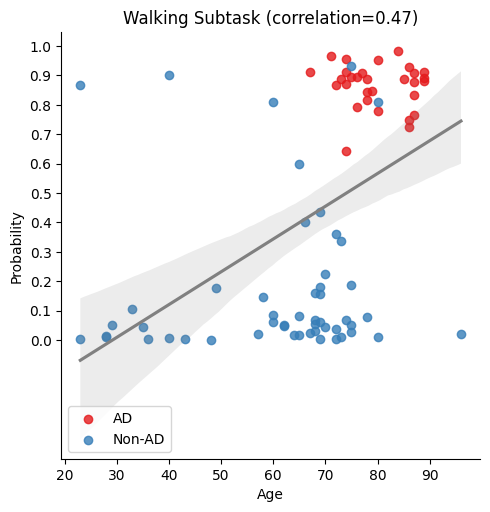

In [63]:
def show_weightedProb_age_relation(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        prob_list.append(prob)
        age_list.append(age)
        label_list.append(label)
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age'], result_df['Probability'])

    hue_order = ['AD', 'Non-AD']
    sns.lmplot(data=result_df, x="Age", y="Probability", hue="Label", hue_order=hue_order, fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()
    
show_weightedProb_age_relation(weightedProb_age_dict)

[Pid 4] age: 71, label: AD
[Pid 5] age: 75, label: Non-AD
[Pid 6] age: 80, label: Non-AD
[Pid 9] age: 87, label: AD
[Pid 10] age: 74, label: AD
[Pid 100] age: 68, label: Non-AD
[Pid 11] age: 74, label: AD
[Pid 12] age: 74, label: AD
[Pid 13] age: 75, label: Non-AD
[Pid 16] age: 78, label: AD
[Pid 17] age: 86, label: AD
[Pid 18] age: 86, label: AD
[Pid 19] age: 75, label: Non-AD
[Pid 20] age: 76, label: AD
[Pid 21] age: 74, label: Non-AD
[Pid 24] age: 78, label: AD
[Pid 25] age: 78, label: AD
[Pid 26] age: 77, label: AD
[Pid 27] age: 79, label: AD
[Pid 28] age: 84, label: AD
[Pid 30] age: 67, label: Non-AD
[Pid 31] age: 85, label: AD
[Pid 32] age: 76, label: AD
[Pid 34] age: 69, label: Non-AD
[Pid 35] age: 80, label: AD
[Pid 36] age: 87, label: AD
[Pid 37] age: 86, label: AD
[Pid 38] age: 67, label: AD
[Pid 39] age: 73, label: AD
[Pid 40] age: 74, label: AD
[Pid 43] age: 72, label: Non-AD
[Pid 44] age: 96, label: Non-AD
[Pid 45] age: 89, label: AD
[Pid 46] age: 87, label: AD
[Pid 48] ag

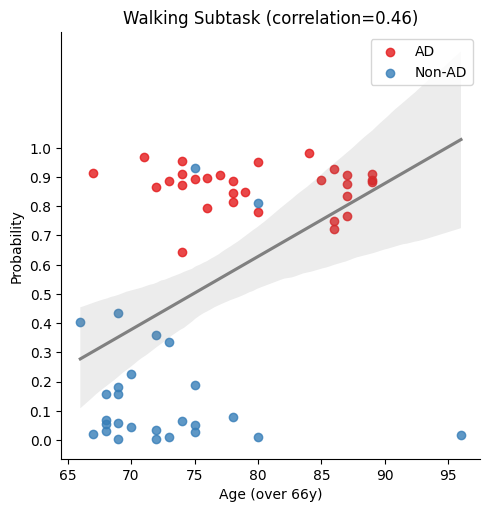

In [64]:
def show_weightedProb_age_relation_over66(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        if age>=66:
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
            print(f'[Pid {pid}] age: {age}, label: {label}')
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (over 66y)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (over 66y)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (over 66y)", y="Probability", hue="Label", fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age (over 66y)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()
    
show_weightedProb_age_relation_over66(weightedProb_age_dict)

## AD only

Number of AD subjects: 30, Age: 67 ~ 89
Pearson correlation coefficient: -0.11


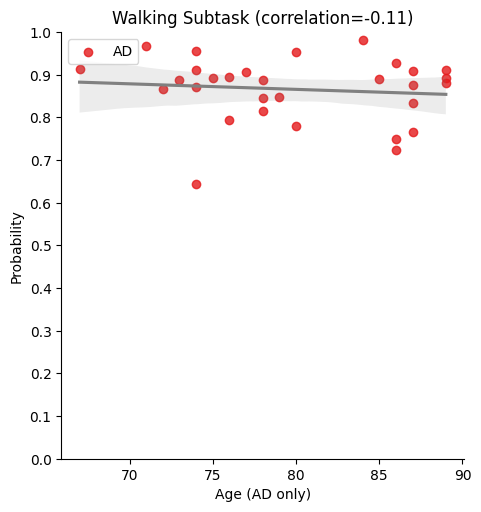

In [68]:
def show_weightedProb_age_relation_onlyAD(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        # if age>=66 and label=='AD':
        if label=='AD':
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
            
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of AD subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')

    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)

    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (AD only)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (AD only)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (AD only)", y="Probability", hue="Label", fit_reg=False, legend=False, palette='Set1')
    ax = sns.regplot(data=result_df, x="Age (AD only)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()

show_weightedProb_age_relation_onlyAD(weightedProb_age_dict)

## Non-AD only

Number of NonAD subjects: 51, Age: 23 ~ 96
Pearson correlation coefficient: 0.0


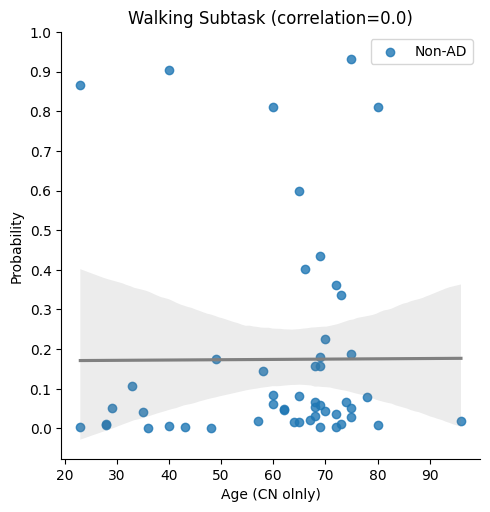

In [70]:
def show_weightedProb_age_relation_onlyCN(data):
    prob_list = []
    age_list = []
    label_list = []
    
    for key in data:
        pid = key
        prob = data[key]['prob']
        age = data[key]['age']
        label = data[key]['label']
        
        if label=='Non-AD':
            prob_list.append(prob)
            age_list.append(age)
            label_list.append(label)
    
    min_age = min(age_list)
    max_age = max(age_list)
    print(f'Number of NonAD subjects: {len(age_list)}, Age: {min_age} ~ {max_age}')
            
    # Calculate Pearson Correlation Coefficient
    r, p_value = stats.pearsonr(prob_list, age_list)
    r = round(r, 2)
    print("Pearson correlation coefficient:", r)
    
    result_df = pd.DataFrame()
    result_df['Label'] = label_list
    result_df['Age (CN olnly)'] = age_list
    result_df['Probability'] = prob_list

    slope, intercept, r_value, p_value, std_err = stats.linregress(result_df['Age (CN olnly)'], result_df['Probability'])

    sns.lmplot(data=result_df, x="Age (CN olnly)", y="Probability", hue="Label", fit_reg=False, legend=False)
    ax = sns.regplot(data=result_df, x="Age (CN olnly)", y="Probability", scatter_kws={"zorder":-1, "color": "white"}, line_kws={"color": "gray"})
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_title(f'Walking Subtask (correlation={r})')
    ax.legend()

show_weightedProb_age_relation_onlyCN(weightedProb_age_dict)

# Small Group Performance
* result_dict_sorted
    * 1: {'avegProb': 0.9186, 'n_pairs': 3, 'prediction': 1, 'actual': 0}
* Age_dict

In [37]:
Age_group_list = [[20, 49], [50, 64], [65, 69], [70, 74], [75, 84], [85, 96]]


def analyze_each_AgeGroup_performance(result_dict, age_dict, groups):
    tmp_dict = {}
    for group_idx, age_group in enumerate(groups):
        lower = age_group[0]
        upper = age_group[1]
        
        n_subject = 0
        pred_list, actual_list = [], []
        for key in result_dict:
            pid = key
            age = Age_dict[pid]
            if age>=lower and age<=upper:
                n_subject += 1
                pred_list.append(result_dict[pid]['prediction'])
                actual_list.append(result_dict[pid]['actual'])
                
        print(f'[Age {lower}~{upper}] {n_subject} subjects')
        
        pred_array = np.array(pred_list)
        actual_array = np.array(actual_list)
        matrix = confusion_matrix(actual_array, pred_array)
        TN, FP, FN, TP = matrix.ravel()
        
        eps = sys.float_info.epsilon
        value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
        value_sensitivity = round(TP/(TP+FN+eps), 4)
        value_specificity = round(TN/(TN+FP+eps), 4)
        value_precision = round(TP/(TP+FP+eps), 4)
        value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity+eps), 2)
        
        group_name = 'group_'+ str(group_idx)
        tmp_dict[group_name] = {}
        tmp_dict[group_name]['Accuracy'] = round(value_accuracy*100, 2)
        tmp_dict[group_name]['Sensitivity'] = round(value_sensitivity*100, 2)
        tmp_dict[group_name]['Specificity'] = round(value_specificity*100, 2)
        tmp_dict[group_name]['Precision'] = round(value_precision*100, 2)
        tmp_dict[group_name]['F1-score'] = round(value_f1_score, 2)
    return tmp_dict
    
age_group_result = analyze_each_AgeGroup_performance(result_dict_sorted, Age_dict, Age_group_list)

[Age 20~49] 13 subjects
[Age 50~64] 10 subjects
[Age 65~69] 19 subjects
[Age 70~74] 16 subjects
[Age 75~84] 18 subjects
[Age 85~96] 12 subjects


In [38]:
age_group_result

{'group_0': {'Accuracy': 61.54,
  'Sensitivity': 0.0,
  'Specificity': 61.54,
  'Precision': 0.0,
  'F1-score': 0.0},
 'group_1': {'Accuracy': 70.0,
  'Sensitivity': 0.0,
  'Specificity': 70.0,
  'Precision': 0.0,
  'F1-score': 0.0},
 'group_2': {'Accuracy': 63.16,
  'Sensitivity': 100.0,
  'Specificity': 61.11,
  'Precision': 12.5,
  'F1-score': 0.22},
 'group_3': {'Accuracy': 62.5,
  'Sensitivity': 71.43,
  'Specificity': 55.56,
  'Precision': 55.56,
  'F1-score': 0.63},
 'group_4': {'Accuracy': 66.67,
  'Sensitivity': 81.82,
  'Specificity': 42.86,
  'Precision': 69.23,
  'F1-score': 0.75},
 'group_5': {'Accuracy': 91.67,
  'Sensitivity': 90.91,
  'Specificity': 100.0,
  'Precision': 100.0,
  'F1-score': 0.95}}